In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [3]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      #mutate(within_x=mean(pInGaze**0.5)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [5]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
dots_shown,dots_counted,pct_area,seen,n_look=[],[],[],[],[]
for i,subj in subj_group:
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]))
    n_look.append(list(subj["nLooks"]))

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
unseen = dots_shown - seen



with pm.Model() as mod:
    #group-level parameters
    
    #mean slope
    b_seen_grp = pm.HalfNormal("b_seen_grp", sd=10,testval=1)
    b_unseen_grp = pm.HalfNormal("b_unseen_grp",sd=10,testval=1)
    #b_nlook_grp = pm.HalfNormal("b_nlook_grp",sd=1,testval=0.5)
    
    sd_seen_grp = pm.HalfNormal("sd_seen_grp",sd=10,testval=5)
    sd_unseen_grp = pm.HalfNormal("sd_unseen_grp",sd=10,testval=5)
    sd_nlook_grp = pm.HalfNormal("sd_nlook_grp",sd=0.5, testval=0.1)
    
    #noise sd
    sd_noise_grp = pm.HalfNormal("b_noise_grp", sd=10,testval=5)

    #alpha hyperparams
    theta_seen_grp = pm.Beta("theta_seen_grp", 1,1)
    theta_unseen_grp = pm.Beta("theta_unseen_grp", 1,1)
    lambda_seen_grp = pm.Exponential("lambda_seen_grp",1)
    lambda_unseen_grp = pm.Exponential("lambda_unseen_grp",1)

    #subject-level parameters
    b_seen_subj = pm.Normal("b_seen_subj",mu=b_seen_grp,sd=sd_seen_grp, shape=(len(seen),1))
    b_unseen_subj = pm.Normal("b_unseen_subj",mu=b_unseen_grp,sd=sd_unseen_grp, shape=(len(unseen),1))
    b_nlook_subj = pm.HalfNormal("b_nlook_subj", sd=sd_nlook_grp, shape=(len(seen),1))

    alpha_seen_subj = pm.Beta("alpha_seen_subj",
                                 theta_seen_grp * lambda_seen_grp, 
                                  (1-theta_seen_grp) * lambda_seen_grp, shape=(len(seen),1))
    alpha_unseen_subj = pm.Beta("alpha_unseen_subj",
                                theta_unseen_grp * lambda_unseen_grp, 
                                  (1-theta_unseen_grp) * lambda_unseen_grp, shape=(len(unseen),1))

    b_noise_subj = pm.HalfNormal("b_noise_subj", sd=sd_noise_grp, shape=(len(unseen),1))
    #a_noise_subj = pm.HalfNormal("a_noise_subj", sd=10, shape=(len(unseen),1))

    guess_mean = ((1+b_nlook_subj*n_look)* b_seen_subj * seen * (1/pct_area) ** alpha_seen_subj + 
                  b_unseen_subj * unseen * (1./(1-pct_area)) ** alpha_unseen_subj)
    noise_mean =  b_noise_subj * guess_mean
    #noise_mean = (1. - pct_area) * b_noise_subj + a_noise_subj

    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=noise_mean, observed=dots_counted)
    trace = pm.sample(steps=2000, tune=500, cores=1, njobs=1, chains=1)



summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (1 chains in 1 job)
NUTS: [b_noise_subj_log__, alpha_unseen_subj_logodds__, alpha_seen_subj_logodds__, b_nlook_subj_log__, b_unseen_subj, b_seen_subj, lambda_unseen_grp_log__, lambda_seen_grp_log__, theta_unseen_grp_logodds__, theta_seen_grp_logodds__, b_noise_grp_log__, sd_nlook_grp_log__, sd_unseen_grp_log__, sd_seen_grp_log__, b_unseen_grp_log__, b_seen_grp_log__]
100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


                             mean        sd  mc_error       hpd_2.5  hpd_97.5
b_seen_subj__0_0         0.740170  0.046242  0.002511  6.396287e-01  0.826482
b_seen_subj__1_0         0.745924  0.042984  0.002288  6.586331e-01  0.823892
b_seen_subj__2_0         0.896901  0.074333  0.004328  7.442109e-01  1.023998
b_seen_subj__3_0         0.827915  0.069781  0.003818  6.857792e-01  0.955737
b_seen_subj__4_0         0.885598  0.064722  0.003893  7.607679e-01  1.004402
b_seen_subj__5_0         0.784492  0.060200  0.003074  6.638151e-01  0.897381
b_seen_subj__6_0         0.829171  0.051882  0.002768  7.258606e-01  0.920917
b_seen_subj__7_0         0.855170  0.056438  0.003096  7.361102e-01  0.950104
b_seen_subj__8_0         0.792478  0.077244  0.004269  6.508467e-01  0.951358
b_seen_subj__9_0         0.771063  0.049462  0.002940  6.705331e-01  0.862119
b_seen_subj__10_0        0.604531  0.036504  0.002148  5.314753e-01  0.683017
b_seen_subj__11_0        0.548683  0.039097  0.002013  4.635951e

In [6]:


summary_mean = summary["mean"]

vals = {}
rownames = list(summary.index)
for i in range(len(rownames)):
    rowname = rownames[i]
    if "grp" in rowname:
        rowname = rowname[:rowname.find("_grp")+4]
        val = [summary_mean[i] for _ in range(len(data_resp))]
    elif "subj" in rowname:
        rowname = rowname[:rowname.find("_subj")+5]
        val = [summary_mean[i] for _ in range(ns[i%len(ns)])]
        
    else:
        print(rowname)
        assert(False)
        
    if rowname not in vals:
        vals[rowname] = copy.copy(val)
    else:
        vals[rowname] += copy.copy(val)
        
        
summary_vals = {}
for val in vals:
    summary_vals[val] = vals[val]
    
summary_vals = pd.DataFrame(summary_vals)
for i in data_resp:
    summary_vals[i] = data_resp[i]
pandas2ri.py2ri(summary_vals)


alpha_seen_subj,alpha_unseen_subj,b_nlook_subj,...,mean_abs_err,pct_err,abs_pct_err
0.044175,0.051573,0.010376,...,2.000000,0.111111,0.111111
0.044175,0.051573,0.010376,...,29.000000,-0.325843,0.325843
0.044175,0.051573,0.010376,...,6.000000,-0.166667,0.166667
0.044175,0.051573,0.010376,...,41.000000,-0.476744,0.476744
...,...,...,...,...,...,...
0.018898,0.112545,0.015407,...,1.000000,-0.047619,0.047619
0.018898,0.112545,0.015407,...,25.000000,-0.500000,0.500000


/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

  warnings.warn(x, RRuntimeWarning)


[1] 0.01330269


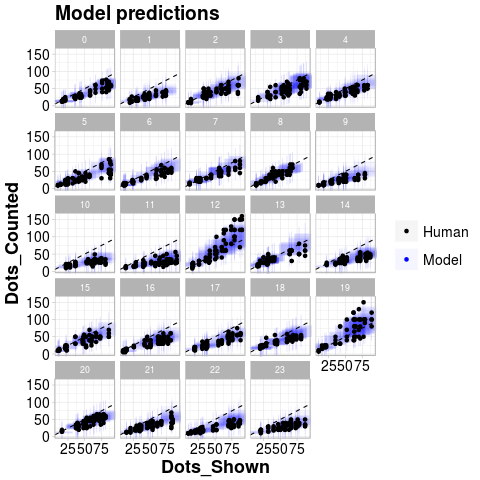

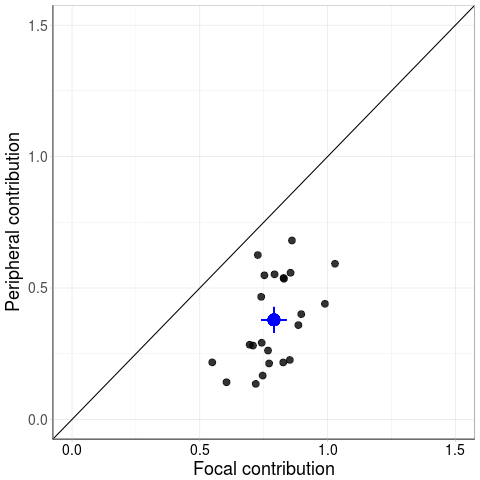

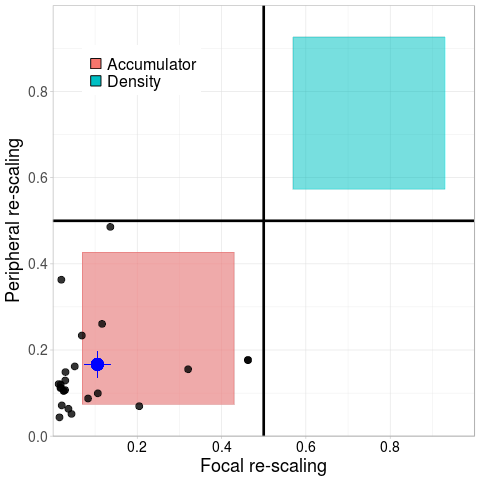

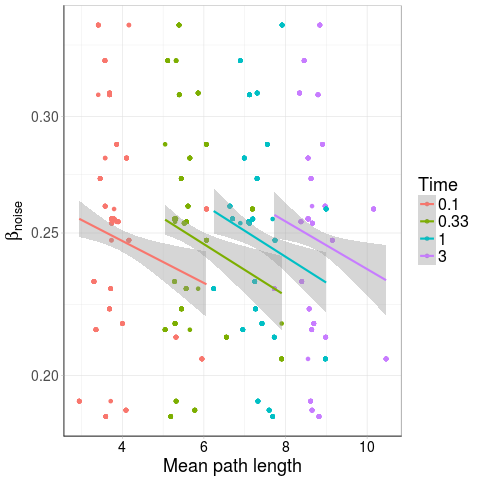

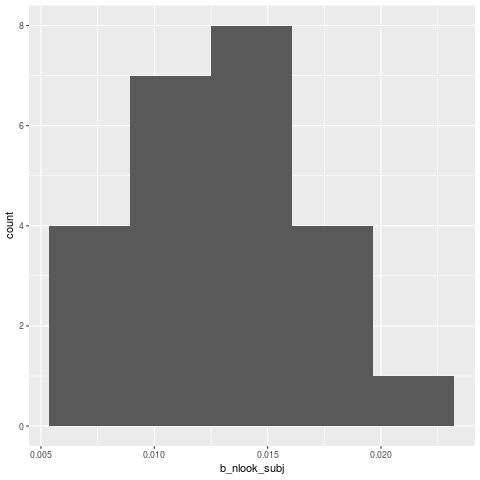

In [7]:
%%R -i summary_vals summary



#get model estimates for each participant
summary_vals <- summary_vals %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%
             mutate(model_guess = (1+b_nlook_subj*nLooks)*(b_seen_subj * within_x_tot * ((1/pctArea) ** alpha_seen_subj)) + 
                        b_unseen_subj * unseen * (1./(1.-pctArea))**alpha_unseen_subj) %>%
             mutate(model_noise = b_noise_subj * model_guess)  %>%
            group_by(pid, Subject, Time) %>%
             mutate(mean_PL=mean(log(pathLength)))

            # mutate(model_noise = (1.-pctArea) * b_noise_subj + a_noise_subj ) 

#just the mean values of parameters
#estimated in the regression

mean_reg_vals <- summary_vals %>%
                group_by(pid, Subject) %>%
                top_n(n=1,wt=id)

p.1 <- ggplot(data=summary_vals) +
        geom_errorbar(aes(x=Dots_Shown, ymin=model_guess - model_noise,
                                 ymax=model_guess+model_noise, color="Model"), alpha=0.04,width=1,size=10) +
        #geom_line(aes(x=Dots_Shown, y=model_guess, color="Model")) +
        geom_point(aes(x=Dots_Shown, y=Dots_Counted,color="Human")) +
        scale_color_manual(values=c("black","blue")) +
 
        facet_wrap(~pid) +
        paper_theme_2 + theme(legend.title=element_blank(), legend.text=element_text(size=14)) +
        ggtitle("Model predictions") +
        geom_abline(linetype="dashed")

p.2 <- ggplot(data=mean_reg_vals) +
        geom_point(aes(x=b_seen_subj, y=b_unseen_subj*0.7), size=3, alpha=0.8) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp*0.7),color="blue", size=8, shape=3, alpha=0.8) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp*0.7),color="blue", size=8, shape=20, alpha=0.8) +
        theme_light() + 
        paper_theme_3 +
        geom_abline() +
        xlim(0,1.5) + ylim(0,1.5) +
        xlab("Focal contribution") + ylab("Peripheral contribution")# +
       # ggtitle("Focal v. peripheral contribution to mean (unscaled)")

 
p.3 <- ggplot(data=mean_reg_vals) +
       #annotate("rect", xmin = 0.5, xmax = Inf,
            #    ymin = 0.5, ymax = Inf, fill= "red",
               #     alpha=0.1)+
       #annotate("rect", xmin = -Inf, xmax = 0.5, ymin = -Inf, ymax = 0.5 , fill= "blue", alpha=0.1) + 
       #annotate("rect", xmin = 1.05, xmax = 1.1, ymin = 0.8, ymax = 0.85, fill= "red", alpha=0.1)+
       #annotate("rect", xmin = 1.05, xmax = 1.1, ymin = 0.8, ymax = 0.85, fill= "blue", alpha=0.1)+

        geom_point(aes(x=0.25, y=.25, color="Accumulator", fill="Accumulator"),
                                   size=80, shape=22, alpha=0.03) +
        geom_point(aes(x=0.75, y=.75, color="Density", fill="Density"),
                                   size=80, shape=22, alpha=0.03) +
        geom_point(aes(x=0.5, y=.5, color="Accumulator", fill="Accumulator"),
                                   size=.1, shape=22, alpha=1) +
        geom_point(aes(x=0.5, y=.5, color="Density", fill="Density"),
                                   size=.1, shape=22, alpha=1) +
        geom_point(aes(x=alpha_seen_subj, y=alpha_unseen_subj), size=3, alpha=0.8) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp), size=8, shape=20, color="blue", alpha=0.8) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp), size=8, shape=3, color="blue", alpha=0.8) +

        theme_light() + 
        paper_theme_3 +
        theme(legend.title=element_blank(),
              legend.text=element_text(size=16),
              #legend.key.width = unit(2, "cm"),
              #  legend.key.height = unit(2, "cm"),
              #legend.key=element_rect(size=0.01), 
              legend.position=c(0.21,0.85)) +

        #geom_abline() +
        geom_hline(aes(yintercept=0.5), size=1.25) +
        geom_vline(aes(xintercept=0.5), size=1.25) +
        xlim(0,1) +
        ylim(0,1) + 
        # geom_segment(
         #      aes(x=0.48, xend=0.2, y=0.48, yend=0.2), size = 0.6,alpha=0.75,
         #      arrow = arrow(length = unit(0.5, "cm"))) +
        # geom_segment(
          #     aes(x=0.52, xend=0.8, y=0.52, yend=0.8), size = 0.6,alpha=0.75,
            #   arrow = arrow(length = unit(0.5, "cm"))) +
        #geom_text(aes(x=0.32,y=0.39, label="accumulator"), alpha=0.9, inherit.aes=FALSE, size=5, angle=45) +
        #geom_text(aes(x=0.62,y=0.69, label="density"), alpha = 0.9, inherit.aes=FALSE, size=5, angle=45) +
        scale_x_continuous(expand = c(0, 0), limits=c(0,1),
                                   breaks=seq.int(0.2,0.8,0.2)) +
        scale_y_continuous(expand = c(0, 0), limits=c(0,1),
                                   breaks=seq.int(0,0.8,0.2)) +
        scale_color_discrete(guide=FALSE)+
        guides(fill = guide_legend(override.aes = list(size=5))) +
        #scale_fill_discrete(guide=FALSE)+
        xlab("Focal re-scaling") + 
        ylab("Peripheral re-scaling")# +
       # ggtitle("Focal v. peripheral re-scaling") 



range_pl <- range(log(summary_vals$pathLength))
p.4 <- ggplot(data=summary_vals, aes(x=log(pathLength), y=b_noise_subj)) +
        stat_summary_bin(bins=12, fun.data="mean_cl_boot") +
      #  geom_point() + 
        stat_smooth(method="lm") +
            facet_wrap(~factor(Time), scale="free") +
              #scale_x_continuous(limits = range_pl) +

            paper_theme_2 
        
range_med <- range(log(summary_vals$medFix+1))
p.5 <- ggplot(data=summary_vals, aes(x=log(medFix+1), y=b_noise_subj)) +
        geom_point() + 
        #stat_summary_bin(bins=8, fun.data="mean_cl_boot") +
      # stat_summary(fun.data="mean_cl_boot") +
        stat_smooth(method="lm") +
        facet_wrap(~factor(Time)) +
        scale_x_continuous(limits = range_med) +
        paper_theme_2 


p.6 <- ggplot(data=summary_vals, aes(x=mean_PL, y=b_noise_subj, color=Time), size=1.5,alpha=0.35) +
        geom_point() + 
      # geom_jitter(width=0.03,height=0.03, alpha=0.3, size=1.2) + 
        #stat_summary_bin(binwidth=0.2, fun.y="mean", geom="point") +
       scale_y_log10(breaks=c(0.2,0.25,0.3)) + 
       #stat_summary(fun.data="mean_se") +
        stat_smooth(method="lm", formula=y~poly(x,1)) +
       # facet_wrap(~factor(Time)) +
        theme_light() + 
        paper_theme_3  + 
        xlab("Mean path length") + ylab(expression(beta['noise']))

p.7 <- ggplot(data=mean_reg_vals, aes(x=b_nlook_subj)) +
            geom_histogram(bins=5) 

print(mean(mean_reg_vals$b_nlook_subj))

print(p.1)
print(p.2)
ggsave("figs/focal_v_peripheral_estimate.png", width=5,height=5,dpi=400)
print(p.3)
ggsave("figs/rescaling.png", width=5,height=5,dpi=400)

print(p.6)
print(p.7)
ggsave("figs/path_length_noise.png", width=6,height=5,dpi=400)
#print(p.4)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOzdd3wU1fYA8HNntmd3k01PSELovUlHkI4FkCb2BuKTh1ifBbvYscsT9SeWx3tPfSKKUhTFQq9BihA6CSQhCWmbZPvszP39MWHZLLub7YWc7yd/7GRnds/szJydvXPnXEIpBYQQQrGHiXYACCGE3MMEjRBCMQoTNEIIxShM0AghFKMk0Q7Ab3a7/fjx4wEsKAgCw0TzC8lut0sk0fzAo/sJUEoFQWBZNooBAAAhJFoB8DxPCIniJmhth0BWVlZSUlLE3i4c4jJBK5XK/Px8fxc0m81KpTIMEfmqrq5Op9NFMYDofgIcx1ksFo1GE60AeJ7neV4mk0UrAJPJxLKsXC6PVgBRPwT0er1Wq43Ml0RBQUFjY2O8J2hs4kAIoRiFCRohhGIUJmiEEIpRmKARQihGYYJGCKEYhQkaIYRiFCZohBCKUZigEUIoRmGCRgihGIUJGiGEYhQmaIQQilGYoBFCKEZhgkYIoRiFCRohhGIUJmiEEIpRmKC9sX79te2LT8L4BufO2ndtB7s9jG8RhM83jfjPjgnRjiK+vVdR0WHrnv16fYTf9+jXcOijCL8nCr34K9gfMdbHHwCgFMB24AHZovdC/vrcu4uE8jIA4L/7Sn7/AsjODvlbBOOZ7wlQAIBnvycvTKXRDicuMZu3UZ4CQN99hQO0io1du0bmfXc+C5QCAOx8Bgb/AyC+a9a3angG7Z79nZcAmrISBco/91jI30LMzuIb2D77IOSvH4wXVirPrz1QCi+vieZAMPGL8hceFjSYI/OmhUubsjMAUIDdb0fmbVFYYIJ2jzQanSd5zhbiN2jerEG52GrlsLPN1tdqN0Qrkjjn9MsjUmMhWiqbTfL44yeeYYJ2j/3bA86Tspl3hPgNJBKQSi+83ZjRIX794Fzb9cMLEwRu6r82erHEMeecLIlUgr5sfrPJjIGReVsUFpigPcjMlN95B8MAUJBPvQn69Qv5O8ifX8R07Aq6VHbGTZKRV4b89YMxoPPfRvR6FoAAIRN6vNstFy8VBkIYeTlLgACkyhnuiqERetck6HoLEAYYgMzB0O7aCL0tCgdCaZz9BLJYLBUVFTiqdwBwVG8c1btVjeqdkZGRm5sbgfcKHzyDRgihGIUJGiGEYhQmaIQQilGYoBFCKEZhgkYIoRiFCRohhGIUJmiEEIpRmKARQihGYYJGCKEYhQkaIYRiFCZohBCKUZigEUIoRmGCRgihGIUJGiGEYhQmaIQQilGYoBFCKEZhgkYIoRiFCRohhGIUJmiEEIpRkmgH4DdKKcdxZrPZ3wWtVms44vGd3W4PIOwQiu4nYLfbA9twoSIIgiAIPM9HKwCbzcYwjCAI0Qog6oeAuANEZkzCKH7OIRR/CZoQIpVKAxv7MrojZloslugGAFH9BDiOi24AUR80llIa3UFjIdqHgNVqVSqVkUnQkXmXcLsU1gEhhC5JmKARQihGYYJGCKEYhQkaIYRiFCZohBCKUZigEUIoRmGCRgihGIUJGiGEYhQmaIQQilGYoBFCKEZhgkYIoRiFCRohhGIUJmiEEIpRmKARQihGYYJGCKEYhQkaIYRiFCZohBCKUZigEUIoRsXfkFdRVlxs+/BdAiCdOQ0GjIx2NAEq1u//bEM/SmFCz3dGdHrA+SmTrXrTsUUqWfLwjo8yTHzvHilbdtYJ9s4K9ZFBfaIdS1AK3gC7AVgpDHw62qGgyMIzaH/o9dYP36YgCCBYV3wLW36KdkCB0IP+0w19KaUA9JdDD245/qrjKYOl8t1fumw9/ub6Q0++s76DAHE87CazcXut3U4FOGoySDdti3Y4gdv9LNgbAATgrbDzuWhHgyILE7Qf7O++fmGCArd2XfRiCdz7P3YEen6Cwi8Hn3I8tfXEO2auVnysN505U7U54tGFDHX6drFT6mXOGNdsEPI4/sZEgcAE7QeqajYiMo3PoyVBrnOeZMiFxzJpgvNTcpk2MiGFBSUtzxMPnFfjUlkn5CtM0H6QPvbMhQkCsicWRi+WwD009rjz5J2j9joej+j0aKIyR3ycmzw0K7FfRCMLKYnTrp0hV0QvkGA5XwggmKBbmfi+ChR58kWLuZefI9Qqefq1aMcSuBen0bfWtTMLjU9fU+38fwmjeOSqkuPn1imluhzd4GiFFxLcFcOeOn36g9NnX+/a4e709GiHE7iBz8K57XB6PaSOgHajox0NiixC4615zmKxVFRU5Ofn+7ug2WxWKpUtzxc2dXV1Op2u5fnCJrqfAMdxFotFo9FEKwCe53mel8lk0QrAZDKxLCuXy6MVQNQPAb1er9VqGSYSP9wLCgoyMjJyc3Mj8F7hg00cCCEUozBBI4RQjMIEjRBCMQoTNEIIxShM0AghFKMwQSOEUIzCBI0QQjEKEzRCCMUoTNAIIRSj8FZvzyorbV8vA4Gy193E5uS5n2fFf2wFuwFA1n8EzJwZ0fDC7NjZNV/svpYKkKpud//4k9EOJ8RePV75VNkJIKS/RrH7ssuiHU7IlBfA6dVAKCgzoPe90Y4GBQ3PoD0wm63vvUbLSml5mX3J21BX7WaenTutu3dTCpSCtWAz7NwZ8SjD6D87JwsCpUCrDKcWr+8Q7XBCqVgPT5adoACU0oIG88R9x6IdUcicXgUgAKVgqoB9H0Y7GhQ0TNDu8Vs3AH++Eq8g2H91U/rZuupLL5Nx7bs/5zpPVhmLohVJOAw8vN158ie9u2/fOFS4FMCpso61InqhoBDBBO1BRpbzvk7SMi6ehVVovUzGtQEdZjtPXmJ7ySBlivMkYS+RIp7JXZtNkjgrg4bcuMQOvZBhe/UlaedrVCYmsqPGXzyP5JkXHeXUCREnLxF5iYMYp1W7a/SO6MYTWmv7diZOlZVrRgyNYjAhlDniwvFMCAx6OJrBoJDAi4QeyR59GgwG4HlITPQ0j3zRe7B/OwBAn0vkIHdYOE04U7/rZOma0T1eiHYsoSeMHPZ9mX6vuXphx47RjiWUBr0I+sNQWwbtx0U7FBQKmKC9UqtbnueSS80OeYmD8hIHRTuKcJnaJmkqJEU7itBL6gZJ3aIdBAoRbOJACKEYhQkaIYRiFCZohBCKUZigEUIoRuFFwmZoTRUtOU3a5F3oY+fd4cPcvz8CAOntc6EbXpppUtpQ+NEfvRigM3r9u0/7W6Mdjh/0ACkbt1BgH8vNeK19+2iFcfobKD8AhIXBz0crBBQT8Az6AuFooe31F7mv/m178yXhr30tL1BcbP3Xh4JABYFal30Ihw+HP8Y40NBQ+vFvPYggUIGu2H/bzqKl0Y7ID7qNWwVKKBUWnSm//siRqMTw1ydQfgAAgPKw85mohIBiBSboC/hd2y483rOrxfmtH71zYYKC9V8fhSOquPPhlgHOt7Ct2T/X46wxZvRffznfPrqioiYqYRjPXHhMAYpWRSUKFBMwQTthnRp8mJY/GQkrbzYpwQ8TACBB1qxzMYmffawL0TT/R5RuAW9+i7YiOzpRoFgQNwdPBEic7udmR7V8Jxb78uuOG4YJEPbld7zO3lrMH3fkQmIj8MiYuCm09FHPfKc7wOG7Tt2jEkb+hAtfDYRA1oCoRIFiAl4kvIBkt5G/+CatqSYpKSCTt7wAgOy1xfZXngcAyZPPhzW2+PLCNLp4fXcb1/DINaXRjsU/wsjLe+7cf5aznho+KFp3GWaOgMxeULAYEpKh2/woBYFiAybo5mQykuXfT0pMzW7dP74w2iEE6ODgPtEOASAJBjwb7RhQDMAmDoQQilGYoBFCKEZhgkYIoRiFCRohhGIUJmiEEIpRmKARQihGYYJGCKEYhQkaIYRiFCZohBCKUZigEUIoRmGCRgihGIUJGiGEYhQmaIQQilGYoBFCKEaFJUFbrdZ58+alp6d36dLl888/dzvPyZMnr7rqqsTExHbt2r388suCIPi+LEIItQZhqQf9+OOPr1+//r///W9xcfHdd9+dn58/evRo5xkEQZgxY0ZmZubatWtLSkruvvvurKys2bNn+7IsQgi1EqFP0CaT6V//+tcXX3wxYcIEAPjzzz+XLFnikmQPHjy4f//+9evXp6WlAcCmTZt++OGH2bNn+7IsQgi1EqFv4jh48GBjY6Mjq44fP37Lli0u81gslpkzZ4rZGQC0Wi3HcT4uixBCrUToE3RlZaVOp1OpVOJkdnZ2VVUVz/PO8wwaNGj58uUAYLVa9+/f/80330yePNnHZRFCqJUIfRNHbW2tWq12TKrVakEQ6uvrk5OTL545Pz+/oqJi/Pjxc+fObXHZU6dOWa1WAKCU1tbW+huY3W43m80BrFGoWK3WAMIOoeh+AjzP8zwv/lSKCkqpIAgsy0YrALvdTgiJbgBRPwR4nifOY6eHTRT3tBAKfYLW6XQGg8ExaTAYCCEajcbtzFu3bi0qKlqwYMFdd9312WefeV+2ffv2AGCxWCoqKtyme+/MZrNSqfR3qRCqq6vT6XRRDCC6nwDHcRaLxdOeEAHiN4RMJotWACaTiWVZudynAePDIeqHgF6v12q1DBOJ3r1SqTQC7xJuof+k0tPT6+rqHF/U5eXlKSkpLh9WcXHxoUOHAKB9+/Zjx459/fXXly9fznGcL8sihFArEfoE3bdvX41Gs2nTJnHy999/HzNmjMs8GzZsmDlzJqVUnDQYDJRShmF8WRYhhFqJ0DdxKBSK2bNnP/LII2lpaUVFRZ9++unatWvFpxYvXpyYmHjHHXeMGTPmnnvueeyxx2644YaKiop//OMfN954I8uyLMt6WhYhhFqbsNyosmjRIrPZfPXVV6ekpPzf//2f4yz4yy+/zMnJueOOO/Ly8lauXPn6669//PHHSUlJM2fOXLhwofdlEUKotSGOdoZ4IV4kzM/P93fBqF8hwYuEeJEQLxJG7CJhQUFBRkZGbm5uBN4rfLBYEkIIxShM0AghFKMwQSOEUIzCBI0QQjEKEzRCCMUoTNAIIRSjMEEjhFCMwgSNEEIxChM0QgjFKEzQCCEUozBBI4RQjMIEjRBCMQoTNEIIxShM0AghFKMwQSOEUIzCBI0QQjEqLCOqXMJoZbl93Rqh8C/2ijGSa6aAuwHkuddfEmrOAQAhRHb9HXDZZREPM0bp9cVv/NabUiAAckb91JTGaEfkN2bDNgoUACQMw10xNNrhtGDXs0ApUACWhYHPRzsa5D88g/aPfc33QuFfAMBv+p3fs8vtPEJtlfiAUmr7elnkgot5Hxf0EQfwoQAWwRDtcPzGbGrKzgBgFwR9dKNpyc5nQTgfLs+D/kiU40EBwATtD0qFY4cvTFWWe5rNeSK8IcWZZp+GHmI8xV1EaDb1tyMxnfNcBrMrWhelOFAQMEH7gxCmdz/HFNOpq4e5Ljym+AE7YaFZi1ASJEUrksDImn3BkOVd3e8AMULmNPYhAeh3Z9QiQQHD/OEf6fQb2NHjmb4DpLfdxXR2f3zKxk85n6OJ/NXFEYwu1v1jXD0wBAgQAt3azox2OH6zjLqcsAQAgMAArSLa4bTgsqeBPf+VKEmDePs2RAB4kdBvSpXkqsktzDN2rGzs2IhEE39enCK0PFMME0YMi3YIfsALg/EOz6ARQihGYYJGCKEYhQkaIYRiFCZohBCKUZigEUIoRmGCRgihGIUJGiGEYhQmaIQQilGYoBFCKEZhgkYIoRiFCRohhGIUJmiEEIpRmKARQihGYYJGCKEYhQkaIYRilGs96CFDhgDA4sWL77//fu9LEkLatGnzxBNP9O/fP1zRIYRQK+aaoHfu3AkADQ0N4oMWFRYWFhYWhj4uhBBq9VwT9NixYwEgOTl5bEtjgpSWlh49evT48ePhCg0hhFo31wT966+/ujzwpLy8vFevXmq1OixxIYRQq9fCmISU0jNnzhw7dowQ0rVr1zZt2pDz46FmZWVVV1eHP0KEEGqlvPXi2LBhw7Bhw/Lz8ydMmDB+/Pjc3NzRo0fv2bMnYsEhhFBr5jFBFxQUXHPNNTt27HD+58aNG0eNGnXo0KHwB4YQQq2dxwT97LPPms1mpVL53HPPbdy4cePGjc8995xSqTQYDI8//ngkQ0QIodbJYxu0eO78/vvvz549W/zPFVdckZ2dfc8992zbti1C0SGEUCvm8Qw6KysLAPr27ev8zz59+gBAampquMNCCCHkMUHfc889APD2229zHCf+h+O49957DwBuuummyASHEEKtmWsTx/z58x2PMzMzv/jii82bN48YMYJSunnz5pKSEoVCUVVVFdkgEUKoNSKU0mbT57s5e+eyVCRZLJaKior8/Hx/FxSveYYhIl/V1dXpdLooBhDdT4DjOIvFotFoohUAz/M8z8tksmgFYDKZWJaVy+XRCiDqh4Ber9dqtQwTiRptBQUFGRkZubm5EXiv8HE9g05MTIxKHAghhFy4fpXpfROVWBFCKKyGDBlCPHjwwQcBIDU1lRDy/fffRyYerAeNEEIxymM/6HHjxnlZrMVSSuFDKeU4zmw2+7ug1WoNRzy+s9vtAYQdQtH9BOx2e2AbLlQEQRAEgef5aAVgs9kYhhEEIVoBRP0QEHeAyLRBB/Y5//777+KC27Ztu/LKKwGgoKCgS5cuACCVSgGguLgYABQKRQhD9cJjgv7tt98iE4G/CCFSqTSwax3RvUJisViiGwBE9RMQ+2tGMYCoXySklEb3IiFE+xCwWq1KpTIyCTqwd1GpVC4PEhISnGt25ufn19TUrFy5cty4ceIV75UrVy5evHjPnj09evRYsmSJXq9/9NFHjxw50r1798WLF4tDoNhstoULF65cubK4uLhTp04PPPDArFmzfOmR4TFBDx482HmSUlpSUlJeXp6SktKxY0f/VxwhhC5BN910k9VqpZRu37597NixRqOR4zhK6e7du6+77rri4mKJRDJjxow1a9ZIpdKuXbsePHjwrrvuKi8vf+qpp1p8cY9fMjua27lzZ0lJyW233WY0Gt95552QriBCCMWryZMnm0ymZcuWAUBdXd20adPMZvPnn38OAGVlZUVFRRs3blyzZo1SqSwuLj5w4MCKFSsA4MUXX6yrq2vxxVuoB+2MZdl77rnnP//5zxNPPLFhw4YA1ybe2J68n/IEAAgQ2aJ3XZ7lN6y3b94AhEiGj2JHeWu1j1NvrWunNxcTAArkxWlRazyNGPmmbTZKgQJhiHDFsGiH482OZwAIAAWpAvq3fCqGwmX27NkKhWLatGl33HEHAMyZM0cul0+ZMkV81mg0bt68GQAyMjIWL14MAHa7HQCsVuvhw4eHDWthH/OvmaasrAwA9u7d6/9axCXrso8oDwAUgFIQuDdfdn5WKC+z/7QaDI3Q2GD/aZVQXhalMMOo3lwMABQAgD6z8hLv8/PIkTM2gTatrUA7biuIdkQe7XgWAJo2DGeJaiitnlibyNGg7DIJAKdPnwaA4uLiRYsWLVq06K233hL/f+zYsRZf3OMZtNjpz1lxcfHPP/8MACkpKX6tQBwrPOw8RWvONZs8cbTZ5LGjkNUmElFFUPPbTMN7++jhw4e7desW1rfw7qNzpc6Tp2y2aEXSIkKbbZpjy6DzHVELBnmXmZkJAJMnT161apW/y3pM0GJdJLduueUWf98mTsn79LTu/+vCdJs852dJ524AF/qrk+49IhZYxBCnHE3ApzIAwYhujn6gbZtXii7k6K5KVbQiaZnThiGA2TmmDRo0CAC2bdtWUVGRmZm5bdu2W265hWGYrVu3irnbC48/WhMuolaru3fv/sILLzzzzDMhXoOYdfPd0PRThRAWZPP/4fwkk5HFTrkOtFrQatkp1zFpGVGJMayydL0BgAAQQl6YGok26MOHD7c8U3i83LatimXFxyxLCgf39T6/i0hGPvgFAAbEb0xJQsTeFgVi0qRJI0aMqKmp6dSpU+/evUeMGFFcXHz99de3mJ3Byxm0wWAIaZDxSv6ax18SACAZdoVk2BURCyby/j5qf+TfNIrn0cYRQ4JZPJKRD1kYmfdBwSKE/PTTT0899dSaNWtOnjzZp0+f+fPnz5o1y6dlvdelo5TyPC+RSBoaGv7444+cnJy+ffuy588yogKr2QUsxqvZuZyBhjzThftGFUf8niLHanZYzc5fHj8pSumiRYvS0tJ27NhRWVnZo0ePqVOnDhgwYMKECfX19ZEMEbVOUWzrCFL8Ro5ijccE/eWXXy5YsKCmpgYAPv7449LSposnv//++9tvvx2h6FDrFr+ZLn4jRzHFY4JesmQJAEybNq1Tp05r1qwBgDvvvHPBggUA8M0330QsvpDAoyV+xe+2i9/IUezweJFQ7ET92muvSSSS3bt3A8Cjjz6q0+lee+21M2fORC7AEDl8+HAAzdYoFkS9f3TA4jfyViuAr9WwbmKPZ9AWiwUAdDrdL7/8Qilt165dt27dxFKNYtm9uHP8+PFoh4ACFL9no/EbOYoFHhN0+/btAeC+++577bXXAGDixImCIHzyyScA0KZNvN4vh0dL/IrfbRe/kaOo85igxcIfX3/99YEDBwBgzpw5e/fuXbhwIQBMnTo1YvGF3OHDh/GAiVPxu+HiN3IUXR4T9Pz58+fMmSORSABg3rx5ffr0Ef/fq1evBx54IELRhQ0eMHEqfjdc/EaOoshjgpbL5UuXLm1oaKiurhZ7dOTk5Hz77bfbtm1LS0sDALvd/tFHH1VWVkYu2JDCAyZOxe+Gw6sgyF8t3NKjVCodtesyMzOnT5/uGP3Fbrf//e9/LyoqCm+A4RS/h3pIxO/qx287lS8VJlGsoTYrrakGzlt1Q47jbrvttiuuuOKxxx5zeWrq1KkBV864xCv8tihOj/NQievVj9Pg4zTsVotWn+PXrOQ3/mpf/R2tqfY02+rVq3Nzczdt2nTs2LEjR46I/6ytrR06dOgPP/wQ8Lv7MaLKpQo7q8avON12cRp2K6E9/Ffqzi3un1vd7B696mEjGzp3Fx/v2rVLLCs6YMCAgoKCrl27AoBOp/vjjz8mT54ccDCYoAHOn9S0zmMmwsmCf+phO28nALLuA+D224N/wSDj/2jL0LNVO4CAlFE9c60x+Hh8FEzY5/ZBxTaQKKD9FFD4PHgGs3ErBUKAftqlwywfCl1Gxu5nwU6BBWh7JWQMj3Y0QaipqcnJyQGAvLy82tpa8Z+EEIVCEUx1OUzQF7Ta85qIrbjkvZfFAdkogPVQgRxCkKAhiPj1+uKy6h0AABRsvOndX9o+OOF0SELyRWBh1x2FU982PT70MfR/wqelmI3bKQUASgFmHzkZIwl697PAUyAAAkDxz7GSoA0duphy2l6YrqniC3aKD9kBQ8FpPClBrnA8TkpKEkcELCkpyctrNrJHMFp7G7SLVts+GJkVJ43Nhs+zfv5BqF45sPiX7h7hPHJUjbEkVPH4KICwq/ZdGEuFM4GpyqelKI3FAX95pw8/vMOp+UOQyewa7YW//A7CNVOFy0cJk6bZ89s5PyU4la4dMmTIvn37AGDfvn1iW0dIYIJ2hTk6YuRjJ4Xw1QKIf0j+I86TJBqHg79hJ6SD89BjCt8KjJOwj1YWCOL0ecdkgE2ISkWysonCWynta6+9tri4eNKkSZ06derSpcvWrVtnzpwZ/FtjgnYDc3SYcE+/6DgQCTAQul+CIn/jH9HpgQsDLRLywjR7aOPxkV+9BtuMBvX5jy1nPDC+NVJ+2qWDY0W1MVNLp8uNTd8cBICJlaACJJVKly1btmbNmldeeQUALr/8ckfVz3Xr1jl6J/sL26Dda7WXDcPdHi1/bXH4Xhz8j/+FabHy29/3yHve7feLz8rMnJWZGfURVVwkdYPBL0Q7iNiGZ9DetM5T6Xhf6/iNP34jR2HSwhm0xWI5cuTIsWPHFArFyJEjBUFwjKonkUiWLl0qFr27hLmc13BvvkKrKigAAZAtCu/JYBR5P5v7etu0g+e+BwACcFP/n7vlTohgaE2+q67+ubZp6LXrM9PGarXOz8Zvh5xwRK4vhqOfAqUAjFLdDnr6NFopignezqBXr17dsWPHfv363XDDDZ999llRUVF+fv7y5cvFZyUSyZw5c9LT0yMSZzQ5n9cIVZXi5WYKwD1+f7RCigAvZ3OHzn0PFIACpfBVwVWheseVZutcfWMJ71ObgyM7A8DyCjddGeL3bDTkkR/5HCgAEAAKxlOhfW0UXh4T9Pbt22fMmCH27HNoaGi4+eabd+7cGf7AQkl75KC8tiaYV2i6jFNf79wdSIjNS+Oh4ylT0Ga9o0LTP8oqCO8azJus3JSa+g8MZqvXweZ9hDlaRJy+8mKnNxvyhccE/dJLL3EcN3DgQMcpc6dOnSZNmsTz/Kuvvhqp8EKAVpan7NraZvU3Wds2MBZLywt4dvjsWefJ1tB+7zZTEC9TgZIzzIdJ6j5SiYXS943mKTX1W2xc8C8b0Rwd0uQXwshpa9hTL1EeN514mrxy5UpHb76EhIQPPvjA8VTckMrMWTlAqbboRN73X2mOFUIQZ2fH23QkQIAAYYj0tfdCGGbMujhT9MqdBUT81UzuGr01VG/UXSr5Qqd9QZuQxJAzvPC3usYH6w0VgvsWj0lJGsfjWzNSvbxsxErfWQ6kmba0ERplLc/qm1BFPuShC1+jyR2Dfz0UOR4vEgqCwLJsamqzXT8xMRHOD1cYL0hySsX4iQklxck7t0gNjWnbNmqPHa4ePMKaFkjrOTt+/EkYD5dEDzwKlPh2/uty5WrmgM9mDvgsHCExBK5TysfJZe8YTN+arb9YbFus3Dy18naVwmVPnZyePtmf6x+HDx/u3LlzaKN1ZjeD9Wgy2BmuVCProFf0qiaK0PSqDsFlwyQY8gIAQKx1s0Mt8ngG3bdvX57n77nnHkcF29LS0gULFgBA7969IxRd6Bhz84smzajrN1BgJfLqc21+/C5tyx+sxRzwC8Zv+6aIUmFL2QOFNZ/4OH8k1zeJIQu1CV8ka7tJWBOlbwB8AHcAACAASURBVDaaptXU7wq6xcNRBDIcJEpQjzkjSTeBQGzHdQ2rOlgOpFEuNI0L8b6zoYB53IEeeeQRAFi2bFmXLl3gfLXTDz/8EADuu+++iMUXQpSV1PUZUDrtRmN+B6BUc+JIzndfJhYeIIG2eMT1YfNX6f9KGn/dV/X2jvKneOqtErlDhNe3j1SyPFn7pCZBw5CTdn5WXeNj9YZqDy0ePjp69GiowrsYm2pOGHc6YWQJm2QFO2M9mGpY3dF2NBmEEDTTx/XO1hq4LdhfXV09YcKEoUOH3n333ZRSl0lfXtZjgr7mmmsWL17suENREAQAkMlkL7zwwnXXXRfcukSTXa2pHDWhfMJkW2ISa7Ol7NraZtVyRUVZy0u6E79De/TKvalX6nwC5FT9yt/O3Gmxe6xE7izCK8sScqtKvjYlcZJCBgBrLLaJNfVfmK18EFcRwr0KkjYG9dWnlEPOMipOsLDmPRmNazpwxYnBX0KM350trlk4/a5TH/yw957dRR9ZuQZPs7kt2P/ZZ5/ddttt27dvP3fu3P79+10mfXl3bzeq3Hfffddff/2PP/54/Phxq9XauXPnCRMmtGvXzq/Vi03m7JyyKTdoCw/oDuyR1dVmr1tlaNexZsBQPiGQW+bj8bYIAqRX6rwkeeft5Quqzft+Kp45MmdJsqJ7iwtGfmVTGeb1RPV1Su7FRtNJO/9yg/E7k+UZbUJfaYCFCsJ+Hz8BWft6adsG2zGd9VCqYJCatmWzh5PZHmeZ7GBLTsfjzhZfSg2/H6v7wjHZaDlr4epBDqfMf50tXqVRZDme6qK7vY16pPjYbcH+8ePHt23bllLKMIxGo3GZ9CWYFnbx9PT02267TSKRNDQ0/PHHH7W1tXl5ecHUn44dlGHqe/Y1dOicUrBdfeq4uuiEqqRY36d/ffc+1P8VjNPaHbmacWrpF5vK5hu5svWnbx2S9XJb7dUtLhWVHDFIJl2Zkvhvk2WJwXzYzt9S2zBdKX9YrdQxAbbzhnstCEvl3WplHetthSmWIzq+TsFvac+nG5WXVbHJgV/8AMzRYWbiyiuM25v96/wuZuT1RmOx4995misdj90W7O/Xr5/BYOjZs2deXl5+fj7Lss6TvgTjceemlC5atCgtLW3Hjh2VlZU9evSYOnXqgAEDJkyYUF9f72mpuMMrVedGjC27aoo1OZWx25P37Mz54WtV2ZnAXi0ef4HqFF2ubPt1umoATy3bzj6yv+pdX2oHR2VNJQCzVYq1qYnjFTIK8K3ZOrGmfoXZKgTaehCBtSBSXt7nnGbySVlHPRDKn0sw/Jxv2tJGaAiqNx42d4RPhmrwoMznHX/tEq6Xc53Ev/bqG52fSlcNcCzlXLDfUQ+jvr5epVIdPHiwS5cuK1eudJn0JRiPZ9Bffvml2GcDAD7++OPS0lLx8e+///72228vXLgwsJWPTdaMrLJJM7THCnV7d0kb6jPXrzXm5tcMutyu0ba8MAD/3deOFPEXUADS3dLIvvhW+AIOLYUkeUzuZ98WXsmx5YdqPj5y7luFrUte8rB+bWd7WSqQ8zhK7WtW8pv/AADprHuYrj0CiDaTYd5LVG9Wci83GM/wwrMNxjfq6juazRre/nJOhxSVf6927/r1H0gTACgQyJPITl8+MICQWsSo7MpB5aR9BV+YbS/Tcme0gfXGM9VA5Zam1mwGAABPpUMvUd4xUX6hu3iHRFqasLPOVJyc0L6NbqCnnqliwf5p06bt27fPcZXuiSeemD59+rhx4+Ryuc1mc5n0JRiPZ9BLliwBgGnTpnXq1GnNmjUAcOedd4op21Hn9JLCMA1de5ZMu7mxS3cgJKGkOPf7r3V7dzF8C8ePsOZ7KlamaPoDAFqoCLD8a7QwRCKzdZRzHQAIz9aY5ftP6ze2uJS/J3HMiaNidgYA7vP/gyC6ZIyQSX9ISbw3QckANLKSfWrNCaXy8TK/K038ZbKOqK8dUV8HFM7YfTpmAsZorfJhp9XjiwPujVex9cK1RgGg4Xhc/miLL4SQ3OQhvXNuzNEN8nLfgNuC/Y8++ujChQuHDBlSVFQ0Y8YMl0mf3t1Tb4/U1NSampqjR4+mpKSkpaVRSg8dOqTT6bKzsxMSEgwGQ4CrGzSLxVJRUeFjC45I3Ik5jpP6VqpcXlOVunOL/FwFANgT1LWDLje09Vi0j1+53G2bgGT6jdC8Vbqurs7x2ycqXO5TcD62j5/7rbBsOQAIrN4iPUIJR6h0TNulGSqfBu/x5TyO4zhuywZ23WrHf2TPvkKcrsoGlmvuOFF0UqmqlUgBQEbpi0maSQqZ28NIEARBECSSZr8a7zl20vF4c5KOjrw8gBhELcZvs9kYhhEDsJepLfvTeb0cABgFL+9RLetUB0wLjTWnVjW7oVyqhtyxTY992QRRv1FFr9drtVom0MsGfikoKMjIyMjNzfVrqQB2wrD+iPH4SYm3C+p0ul9++YVS2q5du27duvE8DwA+prn4ZU1JK7t66rnhY3ilSmI0pP/xc9Yvq2X1erczE4XbxsSmFBEvJzid0seKETN8ksLal6EqSrg/Suac0H/ty+I+rqbQ/sIvR6ZrDxJQnxkXCkHoYTR0NxnkVLAR8ni9YVZd4wk77+PixKni1Qh9XfDx+MhNb7zVfvfGyx164TG2Sl+SPCZosdDzfffd99prrwHAxIkTBUH45JNPAKBNmzYRiy9qCDF07FIy7cb67r0pIcqzpW1++DqlYDtjs4HdTktLaGW5WNODuXrqhd89DAEgQIjkssGOV4qXI6dT+pUABAgwoFBa+yZKugjUvqtiYUHlSxR4AFi9/94f9s399cgzbhf3ZR1pcqrsgcfZK8ZIrp4svTE0Q3p3TlAAQArHDWiovzNBKSWwy8ZNr6l/s9Fk9tpd+u/HTs09dqqHIkHcegTg2dzsiG4sArL29erJJxX9KomcF4xS07Zsw7p29nKP31vtxwEhTd/+UhkAQPFqKFoN1ef71MbFnoZ857GJ46233hJvJhTt27dPLG4HAE899dRLL70UoQAvEoEmDhcyfW3qzi2K8jIA4BXKKq2uwWwGAiQnjx00DADs3/0PAIACECAJGvbKiW5fx2Qy9e/fP4AAQsVLE8fFKBX2V71TWPspAGQkDDbWMlRoahxgiWRS3yVul/Lyc4/jOIvF4qX7Z0iSyyleeLHBuNPGAUAmwyzQqCac/4nj3MTh3LKRLpe82Laty+sE8LvVryYOF5Rjxd54wDMAIMkwKfqda7E3nnOLhyoLMp2ao9zGj00cLYqbJo758+fPmTNH3JnmzZvXp08f8f+9evV64IEHwhdQDLIlJZ+98tpzoybYE9SsxZx57myeuVEh8LT0DDWZoLKyaT4CAECN3lrn4+gEhxCmb/o/hmW/zjLySuNOk2yvwDTdZMGDxwunUV/B9izzuU7zRmJCGsNUCMKD9Ya/6RtP881aPApNJufJKqub1Ynw756m3njXNvXGs1eqDD/nGzd76413dluz9mhTZbNn4+V3G/LOY4KWy+VLly5taGiorq4We3Tk5OR8++2327ZtS0tLi2CEscKQ36F02k117TtRAgq7PdfYkGExsXY7aF264rVQeCG+jpx87aTxef9RStIFYrHI9tvZWgAgXttJY2EFJyrka1MSb1XJWUK2WLmpNQ1LjBcGAcgAX/viRXhFGKVdOahcfc0paW4jANhLtI0/tjfvyqQWNyfdcnnzZd1tlFjYFigYLfzWUCqVKSkp4uPMzMzp06cHPH74JUCQSOpGjD3doYtRIiUUEm3WvLXfakuKnD5GIsn3qeBuHB05yYqeV+UvZ6iGEt4qO2STlChkKS0uFfW1UzPkSU3CN8nafjKJldIlBvOUusZNNjsApKiafYuOUCd5eZ3Ibyk20aYaUXqhN94J973xUvqD4wInIZDuubtNHO1syIVrG/RVV10FAK+++uoTTzzhZbF169aFNy7PIt8GfTFqaEyoLE/ZVyBtrAcAa0papUplM1iYCVeD5zY+k8mkUrk5d4vYvQZ+tUG74AXrz0W36bmDAJCvnTgo80UJo2hxqWbj7UakDfpiFGCl2fqWwVwnCAAwTi57QqPKYpm3yspKjNZnctr7fm+L9y0VTBu0J8698Yicl/eolndu1huvZCPYTdBuJPjyq0A8BKJ4bwu2QfvLNUGLvY7Wr18/fvx4L4v5WCsvHGIhQYsIzycd2p+4fw/D24EQQ4fONQOG8gq/E7QoAodNMAlaVFjzyf7qdykVUpQ9R2T/UyXN8GUpcdWilaBFeoGKgwAIAEpC5iYo7lQppf7XAfWymcKRoAEAKNiKEq0H0gSTFAAYNafoXSVtWx/AWGMuh0DkMzUmaH+57itiNwONRhPd/gZxgbJsXe/LGjt0Tt69TV18Un3iqOpMcV2f/g3de1P/x5ONi3JL3VPmJMo7bTv7aI354M+nr78i558pipZHb4iF4j5JDHlOrZwmk75kshRy9ncM5h/M1me0CYNl/n1nR2EzOdfGK7xQG0/Rt0qSFdT9Yo5kFPWtgzzx2M0uGFar9aGHHlqxYoVOp1uwYMGsWbMunqehoeHee+/97bffeJ6fOnXqG2+8odVqAeDpp59++eWXHbPdcMMN//vf/5wXDOAMWmQ2m4uLi/1dykfK8rKUnZtl+joAsCUl1wwZbs507S3u/QzaRTiOGbe9rAI4Zai3ndxYMs/AlbCMfFDGwnaJ1/qyVMeOHaN4Bg3nu9kRlv3abH3PYG6kFAAmKeWPqpVpAZ3TuWyjcJ1BO6E2xnY41d/eeA6+/IgMa7K+5M+gp06d+t///jeEF+paTtAcxxUVFdnt9k6dOvnYRPDggw+uXbt2yZIlxcXF8+bNW79+/ejRo13mGTNmTF1d3RtvvGG32++7776hQ4f++9//BoBbb72VYZibb75ZnC0zM7Nv377OCwaToB3pKRy5gAiC9vBfuv0FjM0GAIb8DrUDh9mdbpbzK0GLQnu0eOoGG8CnYePrN5c9VGnaAQDdkmf3SXuIIS3UaOV5nuO4fv36eZohMglazI81An3TYFpltlIANUPuS1DerFIEVkXXsY0ikKBFglli/SvNdjJRHFRSmtug6F3FaFsuJBJAK19o98B4TNB2Sn+r0xdZrB2UijFJiexFP47Fj6i2tnbixIk7duxobGyMUIIuKSl59NFHv/32W7vdDgASiWTGjBlvv/12dna2l1c0mUzZ2dlffPHFxIkTAWDu3LnV1dUrVqxwnuf48eOdO3feu3evmHx//vnniRMnNjY2KpXK4cOH33nnnXPmzPH0+iFJ0A4hTwqs2ZRSsEN96hhQKkgk9b3763s0FZgOIEGLQnWQeL9Pwd+PggK/p/I1sbR5tvqKYVlvyFhvNcjFBK1QKDytTiQTtKjAZn+h0SjeF95Fwj6jUV3mZ4uHX0KVoEV8vcx6IJ0r1QAFYKisvV7Ru4XaeCG5DBPM3hgXCbqQs29zGgCz0Gg+am7qON9NpeqqunAEDZfLukpY8QOhlFqt1smTJ69cuTKECdrjvlJbWztw4MBKx10YAHa7/euvv968efOhQ4eSkjz2TDp48GBjY6PjlHn8+PH33nuvyzx6vX7gwIE9ejRVm0xJSeF5Xqx4ffr06by8vMBXyE++n/74iFeqzo0YU9+le+rOLfKaKt2fO9XHj9QMvtyU43qvmu8i01YovrjvnwMBdkDGU0nyzgWVL501bPrl9E2jcj9QS1vedrHT2j5AJvkuJfHfJssHBvNRO39bXeM0pfwfgQ4CUF5eDgBZWVktzhkSYm88vlpp2ZduP6eyndDZihPlXWrl3WuINKiRG73ztIfEwgYNib2c/W1D81YjRdN5VZEAPzo9pWWYrpKm312EEIVCEfLBTDwm6KeffrqyslIikdx5552jRo0ihPz222/Lli07e/bs888//+6773pasLKyUqfTOU4Vs7Ozq6qqeJ53Dn3gwIG7du0SH1NKly5dmpeXl52dbbPZysrKli5detttt8nl8mnTpr388suR6Xkd2kxtTc8smzRDe/xw8p6d0sb6zF9/NOXml/bqBwGdQTtEILX5m6Y7Js3UytptOftgg+3UuuIbhme/nZkwtOXF3F059PetQ0IcBOAauey1RuMvVu47s/U3q+0hteo6hZwJaKxXMU1DpDK1OFKtozee9VCq7YTu4t54EeB9w8VR+m4rYa+UX7iB84zVWsU1/S5Jl0pznZ7KZcP+U8Bjgt68eTMA/POf/5w7d674n5tvvrlXr14PPfTQhg0bvLxibW2tc0pVq9WCINTX1ycnJ188c0NDw0MPPfSvf/3r+++/ZximtLSUUqpWq1esWFFWVvbII4/o9fply5aJM585c4bjOJ7neZ4PYFQXjuN8KZItNuCcPHmyxTkdmOJT7OG/aGq60LadkJ7p+L85t111RnbGX3uTTh5VlRR3LDtT07VndbfegkQCANJffwSOAwAKxD7mStc7wzz7888/xQcdOnTwPUjw+RMAgOzsbN8/AQ3pMTJj2Y6qh+ttx/8o+Vuv5Ic7aG68eDaxheHnIw8CpUCAIcRsfgcuWguXBjS/NoR3lFJKKcdxFz+VCPCqXDKFZRZZuDOC8HyD8Ruj6QmFrJvPR+BDJeUdzU19Kq7XJQHAmTNN4/I47rzleZ4Q4jaAYCWb2VFVpCSFL8yiZpnlzwzrER3b/SyTU+vcG4/nebG5UlT+q+L8iOM0a4Il9FE5EXdajuMkEgnx0MfJ3/3ZO+c19ctwmXS4U0uXSVB9c656W0Pj5YmamWlJyoi0zzh4bINWqVRms7m0tNS5dl1xcXG7du1UKpXR6HHsy1WrVs2ePbu6ummU6O3bt19++eVWq/Xixq+NGzfecsstLMv+61//EptE7Ha7Xq9PSUkRN+H3338/ffr0xsbGhIQE8VmxoaeqqqrtRdVtWmSxWBSKlu+tcOEYoNcTqq8V/ljvmGQnTWuqM+ZELDCtqKoEAHuCumbAUEN+B36lUyVPCuz0G/yNzUEcobJFAXwCLa6+g10wbS9/otTwKwB0SJwxIOMZhjTb4jzP/3RovuA0PtXlnR9LUTUV2vZlFXwPxi239aBd2Cj9zGxdarRYKGUJuUEhu1+t1LTUaXL+8VN2gE7mpoOivVw1NDHh4tmSk5ND2AbtFuUJdzzZWphKrSwAMEkWRd9zjt54zm3Qpgqo3HVhvRiGtp0UvriamM1mhULhKUG3yMf9XLRnz57MzMwI9+K46qqrVqxYEcIf/R6/DcSG4K1btzr/c8uWLQDgPTmmp6fX1dWZzU0tNeXl5SkpKRdn55UrV44ZM2bKlCmFhYWOBmuJRJKamurYfv369aOUOn4zSiQSqVQqfgMz/gtsqe7nEU9cvqsslotnsaWmn71mWumg4WKB6YyN67PXrZILThV8PL66T46eF/JPwNuKNydlE0bkvNcz9e8EyMn6b38vucsm1LnM43IucKjsS+dV8H1b+B6Vv+QM8/cE5Q/J2lFyGU/pl2brxJr6VRab9w3kUnz6jNV9v7eqqqpz585VVFSEKXhCCCMBebdazeQTih41wAqCXmHakGf6PV+oVbnMWXusWZakNHxBXRDknu7XrksC/RoIxrp160LbJOvxy3zw4MFHjx696667Tp48OWrUKAD4/fffX331VQAQRxf3pG/fvhqNZtOmTVdeeaW41JgxY1zmMRqNd9555yuvvPL44487/3/16tWvv/76L7/8InY2KCwslMlkAZwsh4PHFtKUVMdDkpZB1B56MhCiz+9g79hFd2CPtvCAsvJsHgG9VFErV/BAQBKanSkclxN9bxomQHqn3pck77T97JNV5j3riq8fmbMkSd7FMQMDSh4uVJIb2blZaWm/WtidZwt5s3WuhP0gSf2HlXu50XiWF55oMH5nsT2jUXWUuL8ElC6TV9qsx5VNZ81/T8/KSmp2scFxknHxZDiaqolMkPc5J+1cK/bGs1eqDL/kS3MbJD3KQdd0/TB3IJxa77TMJT4IR7zy2MRRUlLSo0ePxsZGl/9rNJrCwkJxgHFPHn744fXr1y9btqyoqOjWW29du3atmKMXL16cmJh4xx13rFix4uabb/7qq6/kTg2vEyZMsFgsubm5V1999dy5c+vq6h5++OGZM2e+/vrrzi8e2m52gXHJCFRfR4tOACshHTsTlZvftiJHNztZvT5lxyalWGCaMFVKlWnmrRCeL3znRBbkJ+B7HqyzHN5Yeq/JXiEhyqHZr+ZqJsD5bnbrjzwkjhCmU7Yd0fVJX8IOVZC+NHG4sFD4yGj+3GTmKEgAbktQ3pugULnbUvceOyk2eaZIpK+0d9+V5eJuduHO1OC2N16vaqK0A0D5H2BpaCq/2M6nm42CZTKZlEplwOe2fu0Vl8at3t76Qe/Zs2fu3LkFBQWO/wwYMOCjjz5q8S5wjuPuv//+7777LiUlZcGCBbff3jR2xpAhQ3JyclasWPHqq68++aTrwVlVVZWamnr48OEHH3xw165dOp3ujjvuePLJJ12aR2IhQTv4tTld+kGrT59K3rVVYjQAgDU9s3rwcGtKGOu4duvWLSSfgI+rbOFrNpc9UGX6kwDpmTqvZ+o8gRfEftC+v1cwu/7FcQaQoEVFdv7FRuMOmx0AMhiyQJvgfJXfd770gw5TXz1HbzwAAIkQgd54bmGC9lcLdxIKgnDq1Cnx4kzXrl3bt2/PRPYi5sViKkGLfNyoF9+owvD2xAN/Jh3cT3g7ENLQqVtt/8GC3O8rmT5yXCMKcpfycX15attdsfBU/UoAyNVMGJTxErVL/L1KGfze74g24AQt+slie91gquQFABgmkz6jVbX1s9OrvzeqhLzHnuWM0n4wy7k2nqxTHWEj1xsPE7S/wlKLI6xiMEGLWty0nu4klDY2pOzaqiopBgBeLq+7bHBDp24Qhi/Ci28kC+0pqltHapftq3pToLxO3nVI2ts6dX4A7xWSY+DQoUPBJGgAMFL6vsH8X5OFB5ARMlul+FuCQuFzugnmTsKQJGuO46QSqa040XogTTBKAYBJ4BR9AqyNFwBM0P7ymKAppcuXL//yyy+Li4t53nWM5IMHD4YvJu9iNkGLvGxg77d6q0pPp+zaKm2oBwBrcmr14OHWjBD/zvV+p284RuETlRu3bi37h01okLPJV+QsTlNe5u8biYI8EsQe9DKZLMiLikc5+4uNpj85OwDksOwTGuVo31o8QnWrd8At144dgPJErI3n6I2n7BdsbTxfYIL2l8cE/f777993332eFouvetCiSI6Y6XYzt1iLg/B84qH9SQf2MHY7EGJo36lmwFBeGdTNh858LMXg1w7n4w7dYCveWDKvkStmiHRg5rMdEmf4/hYuAj4eHAna8Z+AMzUF+N5ie6vRVCsIADBGLn1Sk5Dd0l0toa3FARd1DoGW8rXLDuCmNl7fc2yKr7XxAoAJ2l8eE3Tnzp2PHz8OAD179rz4Dp/vv/8+fDF5FxcJWuSysX0slsQaDSkF29VFJwBAkMnqevdv6N6bhqLFI3zFzHzZrS2cfuvZRyrN2wCgi+62yzIeIxB44YIAjoqLE7Qo4DRdL9B3DaZvzFYBQEFgboJqlkrhZRCAkCdo0cVp2sElX7vdAdzUxutTxWh8uuPUX5ig/eUxQavVaqPRuHTpUi+F5aIijhI0NN/eflWzU5SXpe7aIqurBQBbYlLNkCvMWa4Fpv0VZDGzIAd84nnexlmPNC45XPM5AGQmDBue/ZaMTQw4nhZDujgAtwlaFHCaPsjZX2g0HeTsANBOwj6tUQ31UBIvTAnawUumFqWmpnraAbz0xgshTND+8nheJtbtdanFjPzVrVu3wLafJatN2bXX1wy6XJDJZfX6rJ9Xpf/xs9gnL1oOn+f2WV9WkwDTL+3RIVmvsERWYdy2rviGBtup4EMK5hUcAt5SPaWSr3SaZzQqLSFFdv6uusZ/1BvEzh4RlpWV5b2Jw7k4pQs3I9WudjNSLfKkurp6woQJQ4cOvfvuu0PYAsw+//zzbp/IyclZvny5Vqv1Pjhh5NntdoPB4KXeqZcFQzsmoe/S0tLS0tLKy8v9C4AQa1pGY6euEqtFVlcj09dpjhYSoNa09MD6eAiCEJJyiNVOHJWA4PxqOsqwuKCUip0odIqumQlDyowbTfby4obVSYquGllQN4teHImnACil3j8B76vgCUNIL6lkulJRS+lRO3/czq8wW+WE9JJKnLeTWCwp3B1VNRqNRqMxGNx8l1NKxXGLPGFUdln7ekmyRahXUJOUP6eyndQBQ1mdhYQiavE3XMBn0C1uYmdnz55Vq9WJif79RHO76a31YK4EwgDrrqCZGNX7779/+eWXL168+NNPP+3WrVtmZqabWf3nsYnjxhtvLCgoOHny5KBBg/Lz810+U5dhqCIpvpo4nNXV1el0usDO+ORVlak7t8irzwGAXaOtGXS5MTff3xcJ+bC5LryXbHUU7BcnTfaKTaXzay2FDGH7pD3cLdnNuGjBxOA2AC9NHBcLbEvt4ewvNZqOcnYA6CKVPKNWOgYBCHcTx8VcGj14nvd+D/AF4ki1f4W4N15cNHFQq0QwXthG5iqoLWx6nNwDlBcqOwBRcYyCF6Pau3dv27ZtdTrd9OnT33zzzVBV5vOYoL1/iNiLIwBigoaAmzsp1Rw/nPLnTsZiAQBTm7yawcM5rR8nCOFO0N65JGgA4KllR/lTpxt+AoB2idcOyljIMr7WXPXO7ZHsb4IWBbCxeID/mizvG8xGSgnAVKX8H2plMsNEPkFD8xztR4IGALe98fpWSbIDb2eLiwRtPaazFPh0/qscVCHrWOeIymAwDB48OC8vb82aNaGq3O8xQXfs2NHLYidOnAjJ2wfgEkjQosDSNGu16vbu0h4rBEGgLFvfo4++d3/Bt2M+wgna5d6KixM0AFCghTUfH6j+J6VCiqL3FTn/VEpCdr+7ahjiawAAIABJREFUy/EcWIKGQLdUJS+8bjD9ZLEBgJaQBzWqqQyRsJFO0CJxW/iboEXUxlgPp1iPJAffGy8uErTtZJJlb7rjP5QHev6CAmHAeehNxWWVsvb1YlT19fUajYYQ8tBDDw0fPvy6667z6309CfxOQrvd/sknn0ybNi0jIyMkofjokknQEETPAXltTcqOTYpzFQBgVyXUDhxmaOftC1UU+TNo59M3SinP824PmFLDb9vOPm4XTEpJxhVt/pmi7BnCGBxHdcAJWhTYxtpu415qNBXZeQDozjLPqJV9FKH5leCv8vLywBK0yKU3niSnQdnHp5FqncVFgnb5j7UeyjY0Pc4ZDbKL2vDFqObNmzd9+vRx48Y9/vjjffr0cQx7HaTAE7TFYlEqldu3bx8yZEhIQvH9fS+ZBC0KuMVDXXQ8Zfd21mwCAEtWm+pBw206N8PWOESlicORo8UELZ4/XtzZoM5ydHPZfQauVMIoBmW+mK+dGPJIOnfuHEyCFgWwsTgKn5ks/2c0WSgwANcr5Q9qVNpoVCsOfgfgG2TW/ed74xEq6+Bfb7x4TNAAQAWwm0GiBLdXSsWoioqKbr/9do7j8vLy/vOf/8h9HiDJO+xDE30B9qMkxNC+c8n0m/U9+lCGUZSXtVm1PGXXVta3Qa0ixsd7kXWKLlfmf52hGmQXLNvPPra/6l1KQ9xT7ciRI0ePHg3yRQLYWFIC9yQoVqckjZJJBID/ma3XVNevNFujchknyE67rNapNx493xtv/yXeG48wIE1wn50d2rVrt3nz5h07dixfvjxU2RkwQceIgDvhClJp7cBhZVNuMGfnEkoTCw/kfPel5sQRiKUaWD7maDmrG537ScekGyjQQzUfbyq7jxM8jqwWsOC7Tge2sdqwzLsJin9qVTksWysITzUYb69tOGZ3rXITAQHvbA7iSLUJo0rYJCvYGeuh1MZVHa1HkikfhZ8FlzZM0DEk4MPGlphUPmFS5egr7WoNazGnbfmjzY/fiX3yYkRWVpYv1yoYIhmU+dzAjGcIsGWGP9afvtlgKwlHPCFJ0wEsNVIqWZWi/XuCUkbIHs4+o6Z+UaPJGI1v0+Dvf5NkG9RXn1IOOcskcNTKWv7MMKzpwBUlQgydG8Q9TNCxJZjDxti2fcnUG+v6DqCsRF51rs3a79K2bRT75MUIH2806KS7aUzuJ3I2SW89/vPpGyqNO8MUT5BpOrCNpSDkPrXyhxTtMJmUB1hmskysqf/REoWGqRDco0xA1r5ePemkol8lkfOCUWrant34Uzv72VCOy9eaYYKOOcH8AqUSSV3fgSVTbzDm5gOlmmOFuSu/1B45CEIU7jx2y8fmjoyEwVe2/TpJ3snK638vmXO87qvwheT9FnbvAt5YbVn2E53m7UR1Bsuc44VH6g2z6xqKIt7iEXxzBwAQlooj1cp7VIsj1Ro35Bp/a8vXRPOa/KUBE3SMCuawsWu0lWOvrhg/idMmsVZr6o7NbdasEPvkxQIfc7Ralju+7Zdt1KMp8LsrX9xVsVCgIa7d4yKYNB3YO16lkK1JSbwzQcEC7LDZp9bWv2swWSLeRBCScj9EJij6VGmuPSnrqAdCxZFqjZvbCA1BdZtp5bCbXeR46mbnRZDtpEQQEg/tS9r/J2PngJCG/A51A4fxnoe1DSvnG1W6devm46pRKhyofq+w5hMKNEM1aHibd+Ssf5+hg19DXoVj+AIvdxIet/MvNhoLbHYAyGaZJzUJY+Sh7xDJcVzv3r09PRvCwdE99caL/W52sQbPoGNakL9AKcPoe11WMu0m8TYWbdGJ3JVfJR3cR2KgxcPH9SKE6ZP20NDs1yWMotK06+fiG/TWY+GODQI6mw5mS3WSsMt02le1CckMOcsL8/WN8/SG0otGMgqrEJbN9NQbD+yhuQG69cAEHQeCHeopIeHcyPFnr7zWqktmOC65YHvOD8uVZ8PSO8Ivvq9Xvnbi2Nx/q6QZBq70l9M3lxp+C2tgDv42TwfzhUoApijlP6Ym3aRSsIRssNqurWn4yGi2RbCPR2hLG1/ojadr6o3H/dITe+P5xWO5URGl9MyZM7t37y4qKpLJZOLN5o5n8/LyhgwZkpAQ0Z/M8VhuVCQ2CgW2bAA1MF3Y1Zq69p1BpZZXVUhMRs3JY7K6WmtahiCL0J3HjnKj4NSdw/f1UknT22onVpn+NHKlZxp/ZogkTXUZ8ae6mlhuNLBqnz5WNBV5Wilfyo3KCRkpl46USY/Y7Wd5YafN/pOFay9hc0NRfEcQhBY7OwZWcNULRmOTdaxjNJxQp6AWKV+h5ooTGQXPJlr9rY0XgXKjscZbG/SGDRueeOKJHTt2OP4zcuTIt956q3///hGJzb1W1QbtIshWQvFOX9ZiTt6zQ3PiKFBKJRJ9z376nn1p+Cv4uLRBOz/l+3rxgnVX5XNF9asAoK32msGZL0kYRYtLifxqg/Yi4GHA/KpmJ1D4xmJ912CqFygAXCmXPa5RZbY07KF33tugXYSwSVpEeWI8pBaOZ4m18VidVdHnnF+18VphG7THM+iCgoJx48YVFxc7//P06dNffvnllClT0tPT3S4VAa3zDFoU5NmNWLCfSqSmvHamNnmy2mqp0aCsOKspOmHXaLlEvz9Sv7g9gxb5vlIMkeRqxkkY5TnTTr31WLlxS3bCFVLWp163wZxBO/PxbPrilfKrYD8h0FMqma6U6yk9YudP8Pw3Zqv0okEA/OLLGbRDaM+jAYAwYNfoVV0bGYbYaxXUJOWKE/lzCWyijVH51D+nFZ5Be0zQc+bMOXz4sFKpfOqpp1544YVZs2a1bdt2165dJpPp9OnToarVFIDWnKBFAR85ziOq8AkJjZ272RPUyqpK1mRUF52QV1VaU9MFha8npP7ykqDBz5VKU/ZLVvQ8a9xo4EqLG9emKfuppC0X8A1Vgha5HVPGNc7mKxXAiCpKQsbIZUNlkkO8UMEL22zcr1ZbJ4mkxRHE3fIrQUMYcjTHcVKFRJJpknWoBzvL18kFg8x2KonXyyU6K5G3cFG0FSZoj00cycnJdXV1n3766ezZsx3//Pjjj++55x6dTldbWxupCF215iYOZ4GUVXNXzIy1WXV7d2uOHCSUUoap79FH36e/IAn9N5mXJg6Rv2vUYDu1oWSegTvDEtmgzIXtEqd4nz9UTRxu+TKibjAF+3mAL0yW941mg0AJwLVK+aNqVTLjXyOuX00cDiFs63DpZsc3yKwH0rkSX2vjtcImDo/fw+LdBC6Dxvbp0wcAUlNT3S+DIihUF9x5mbx68PCyyTMtGVlEEJL+2pu78iv1qeORL7fk7xppZe2vyv86M2EoT23by5/YW/WGQKNQe0jkvbNH8BuLBbhdpViTnDhRIacAP5it11TrvzJZ+PBvpvCNWs1qbarh7mrj2bB3WROPTRw8z69bt85oNE6ePFn8Xcxx3IIFCw4ePDh//vzRo0dHNEwn2MTh4G+TtJdBY3mlqrFjFy4xUVF1jjUZE06fUlaetSan8UpVqKL13sQh8vc3Ncso8hMncXxjjeVAtXlfjeWvHM0olrjvlxLaJg63vLR7pKWlVVZWBjlobAJDJihkA2TSv+z2CkHYZOM22ezdJJIM31o8/G3icAhVW4fbQWObRqpNOT9SbZXHkWqxiQPmz5/vePztt99WVFTk5eWNGDGCUrp58+aSkhKFQjFr1qwPPvgg4qE2wSaOi/n4I9SXeu2MnUvatyexcD8RBEpIQ9ce+n6D+eCK3ItabOJwCOA39cn6b3dXvCBQLlHe/oo2S9wOEx7WJg63XFbTZDKdPHkyJAFwFD43mT8ymsVBAK5Tyh9SqxJbavEIrInDIfi2jhbuJKRgK060HvA4Um0rbOJwTdA+3oWJg8YGIHwJGnw7eHwfUENar0/dtVVZdgYABIWypv/gxo5dIbhBQHxP0BBQLqgy/7mp9H4rXytjtJe3eSsr4XKXGSKfoEWOlTWZTCzLnjp1KlSvfJYXXms0/Wq1AYCOYf6hVk5Tyr1spCATtCiYNO3Lrd6UJ7bjOushNyPVtsIE7frLKNE3UYkVeRHahkIuMal8/MTKMVfZNVrGYk7buiF7zbeKCBaYDmB10pSXXZW/XCfvahMaNpbOPVL773AEFrwQbqlsllmcpP4wSZMrYesE4ekG4211jUfDXBIvfE3SIsJSeVesjdfENUHrfROVWJF3IT9yjHntSqbcUNd3AJVIFDVV2Wu/S9u6gbEEMpxzAAJYnQRp9vj8L3I1EwTK/3nutR3lT/E0tgYAE4V2S42US39I1s5TK+WE/Gnjrqupf7XRZBDC+Bs33Dka3NXGM/6ex1vD/bYxB6+WXlJCfuScLzB9o7FtO6BUc/xw7ndfJR4+SCLSxhXA6kiIcnibd3ql3kuAnKpf+XvJbAtfE47YghTaLaUgZH6C8oeUxOEyKQ/wH5NlUm39WksY81kEcjQAMEq7clC5euIpaV6jvGstG53x0KMJE/SlJiQl2F3Y1ZrK0VeVj5/EJSaxNmvKzs1tVn+jqDwb2ndxK4B1IUB6pd47vM07EqKsMv25rvj6OkuI71oOiZBvpjyW+VineTdRnckw53jh0XrjrLqGU3y4KhdGJkfD+d548p5VkXm7mIIJ+tIUjoPH3Ca3dMoNtQOGCFKprLYme92q9E2/scbQj+vqIrB1ydVMGJ//RYI028SV/3L6ljONP4c8sOCFYzNNUMjWpibOVikkADtt9mk1+ncMZnN4fvFELEcDgL+VlS4NmKAvWeE4eCjD6Hv2K5l2k6F9ZwBQnzqWu/KrpL/2hrvAdGDropN3vSp/eZryMp5atpY9/FfN+zT2BjQNx2ZSEvKIRvVdSuJAmZSjsNRonlRTL3b2CLmI5ujWBxP0pSxMBw+vSjh3xdizV11r1aUwdi55z46c778W++SFT2DrImeTx+Z93iFxBgV6qOaj/2/vzuObqPr9gX/PZOmatmm6QKGlQFkKChWpgsomUB58QFD5gcpF3BEeBFREHhVQUAS96hUE5EEQvcpP5HqLCsj2oBRcWLQVEIECLUtpodKkS5YmmTn3j8E0LdBmmcyZab/vP3hlJjOZTxLmm9MzyTk/lT3npjJd5PRdiN6mDK1mrdGwKDbKxJFSXphmqZlabasOwSQAWKNDR+7vhCrad984t+6kQAkBfc++8MADrANJwPfJpbYcesbN2ygAcGRUzw+a3N6RnFIyckzMiaPGX/frqiytd2y2prW/nH2b2xATbGhJcUR3a+sFceGdf7345vmanduLHxzQdlmULsV7mwKLbcWlUvF2u3Ddi2lpMocUa1yDd+r0NwAUgAJHIP3uQB6WANwdHjYoTL+kxv65vdZOIVqKcaWv5vt/M+QXbEHXqd22U/wTmFJwFvzEOo5kfGzguMTqDAAC/argKZ8emuOqut5w7t4HqjtnAiFRZ4tSv1pvLDhI3CGZ3TWYlloX44SBbT/QczGW2uPbzoy9ZDvofe8Hf1VnADjjcAUeMTjeT7A0H0AAsUtGoHBme+APayDkJUPkF/Exc6PCQ9eRi+3oUMAC7cXrQgptXlckmjx5yiwF9Zb9uaYkhEeU3zbwwoj7ahOTiNttLDiQuvHzqDNFAeRsUjBVIDmy75DUdTH6Dg53xa5zj520bPDcpZyeac8TdJ6vt553BP3IWk274Mb7b/oQWKOlhgW6TnC/ZFa6zMzMTp06Xe/eVnFZ3s+e83McSwBwmBJL7rq3/PZBfHiEtqY6+butrXds0lWaAwrbmGCqQLQuLafd/28d1U+grv1l8w5efJ0CD563noISarX4BKMy6q3UK6vf6LqwRksLC3Qd/aNTr8xxRyBs7FjWcUKikfMnSp8CAASAAzLShz7oayCkulPX8/c+WJl5IyUkouRc26++iD/4E+eSuNMgmCqg1xgGtF2eGf8IAJwwf7br7BNOvvL1Nh0JiF/kIv2jQzuzjC8yMzMTMgE4IAQIASDQdiDrTD7DGi2hxuYkVCYcLClgnldAhus5evPlhH17w8suAAAfGXW5d9/KtPYut9vHwZJ84e+zaDBYUlHl1/svzuOF2mhd2oDUZbH6jsFHuqYGgyWFhfn6ezjJ3yZJBkvy0TXD+zJYUiNwsCTUIsjQxnEaTRf+NurSgKHuyCiNzZqUt7Pt9m/CLVJOxBPks2gfe/eQtI8jtIk1rrPbix8oqdktVTCpqLopqurwyoEFuoWS5/ypaZ9x/t4HLTf2ohwXcams/bavE37eo3FKNkZEkM/CFN5jWLv1pogbXEJNXsk/jlasliqYVFRd5lQdXiGwQLdc8pw/glZbcfOt50ffb01JJZTGHDuS+r/raLl8I5c2LlLXanDqJ+kxf6dUKLj09o8XXuAFZY2Zpuoyp+rwSoAFukWT7fxxxcReGDz8XL/BbkOMKzqGJPgxd1Hjgn8KWi68b8qbPRNnEMIVV32z8+xDdrdSPj9Eqi5zqg7PHBbolk7O86e6Tdq50eMuDsyR9iuNwT8FAqS76cl+bZbquKjLjsNbi8dWOI5Ikk0qqi5zqg7PFhZoFJIRSq+HarTuaIPkDytJ/rbRg4a2WxetT7W7L+04O6G4alPwjykhVZc5VYdnCMfiCJbr3cXCxQuEgkan1bz2Nus4gfNlOIUyS8H+og8ooUDJ0JveiYRrz/l92Vp4+NznAvBdWo1oE9e7yUP/q7T0qRNFFIAAEQb0DSS9RMNBxIV1GtZu/d4Lz1y07vvxwixL7YmeCTMIaaIdU5oPjrNAATiA9FFBRmiMqoe8yMzM/OWXX1inUBlsQQfn/HmhrAQopUDdLpfrzddZBwpKk82cfUUrKFwZsGTnb89ecxuX27b3xH9W2s9X20sPFq2qtJ9r8riTjp+mlAKllArc9z8GkFwkSTMtTBM3qO2qTsYHAODo5Q/zSqa6hJrGd3Gcu/IDRAGg+OvgIzRG1U3Rjh1D9WXz5goLdFDca//lvSiYL7JKIpUmzn+vrmN6nVnvLtUc9V48b97vV4AgfzclSf3iiDY7ec4treZxRFtS8/32Mw/WuK7/MWOrN3KJDD/8UnWN7tq1K+sIaoIFOija/vX+HtdqdKySSMjX8/861/mMEe28F+Mj/Ws0BX/1UKr6lRE3blDqh2EaY2XtyW3F4y7a9l17u/rdPFSWU0rVNVrV4WWGBTo4/YcT4K4M4EGIqvugvV3vFIrVJ18poATSk+685jaRYYmdW/1NvJ1qzG4dl9Xk4dLCI+GvF/H1Ngr6Kzg58pZh6evjwjrX8pZdZx8/YV53zc2IBjwvS4fBMmVTdZlTdXg54Vgc8lHOWBw+kvZ6FM/zLpdLwrE4Gnd1+AZjcfjOLdh+vDDrfM0uAMiIG9s7+SWO+PGnUsBjcfjCr/dIzrE4rsliscTExHDclXahv//BcCwOhOqoupkjYXgtF9mvzZLupkkEyEnLF7vOPeZwSzmoSDDwPWresECjxqj6FJIwPCFcz8Tpt6X8p5YLv2Q7uO3MOLPjuFQPHiR8j5oxLNCoCao+haQN3y5m+JC0/47QJltdJTvOjj9XvVPCBw8GvkfNFRZo1DQ5f2ooOWmTx4d3H56+ISEiyy3Y9pZMP/LnCqqASVhA5WVO1eFDCgs08pV6zyJpk4drEwanre0Qew8FeujPpT+UPMvToGcMlIJ63yBQefjQwQKN/IBnkUhD9H1av35T4vMc0Zyt3rbjzH/Y3GWsQwGo/A1SdfgQwQKN/KPSsygUsTNNjwxou0LHGSocR7cW/b9ye77khwiASt8gkarDhwIWaOQ3lZ5FofiRceuoO4alfx6jT3fwl3edfeR05f9KfogAqPQNEqk6vOSwQKNAqPQs6tKli+SPGaNvPyx9fevoO3jq/Ln05V8vLRYoL/lR/KXSN0ik6vDSwgKNAqTSsygUsXWcYUCbFV3jHwKAYxUf7y6Z7BKqJT+Kv1T6BolUHV5CWKBR4FR6FoUiNkc0vZJm92n9moboS2v2biseV+Uskvwo/lLpGyRSdXipqG/Afkqpy+Wy2+3+7lhby3gyULfbHUBsCYXiFUhPTy8sLPRlS57nxeE4AIDJ6yCOxcHzPACIMSSXGjkyIiX1p7Jnq5zF24rH9Ul+s1Xk7Z4n63Q6OY4TBCEUh74e7zcosBNHQmIAz1gcTWrwv8uv8DK/ziGivgJNCNHpdIENe8R2sCSHw8E2AITmFejRo4cvo96Ip6VOpwtRjCaJnxB6vR58zhyA1rrsv0Vs2H3+H2bHHz+UPd0z8bkeEYvFuyilkg+W5AvvJ8v2f2BtbW1ERITvBRqCCO/XURSrOTwHxJwa/xoNXeZIbauh7T5NNeQIlM+/9OavZz4K0YF8p8Y3yEPV4YOEBTpoxcWsE4RcseWnJrdR48/Brw582majAO6gx+DVkog72ryblfhsYmSvHqkPBvloV6s67/cuqnt3vKk6fDDU18WhKLWzp10ZiYFwYYv+i3GaEFj/4z1HLm0Un6OWRM0b3cTsfKqb1dQT+NnC01avutw5Ivy51DbBPDIB0s30eNf4h7WcpH0aVfDzW1ducgC3LPBj106dOkmZRF4ts0ZjCzpwtbNn1I2TQwXYsJZhmBD5/eJGz3N0g9WXXVR3IomBrfVbzSfsjn1VEnxVjiMSt4H2v1V3WwCo8ukCLVIrLNCB40i9y8TuoydZJZGJz3/3q65GX1OZMyTf9AhSgzkPzzXd+YRUDAt04GjrtnULBLTTZ7LLEiqUBDiJq7pqdGZm5tXP8/ZYA4MoTYmIq7fY/SFGOZAssEAHTj9tlsYQS4AQQsJu7gVxcU3vozYLRguEcIQAR8hzg/z75YW6avRXo0YQIABAgHSNjPhnWtsEnRLnaO/xDGgjgAAQgAy5JqhFrOBFwqBoX/bnGo06zR8d+MgSKrpmGAewe9TfVZG294usEyC5YAsahZa62tHqSouaPSzQKOTUVfXUlRY1b1igkRyw6iEUACzQSCahGIs5RPDjBCkEFmgkn4yMDNYRfIU1GikBFmgkKxUVPhVFRc0VFmgkNxUVPhVFRc0SFmiEGoM1GjGEBRohhBQKCzRCTcBGNGIFCzRCTcMajZjAAo2QT7BGI/lhgUbIV1ijkcywQCPkB6zRSE5YoBFCSKGwQCPkH2xEI9nggP2oHtc/pwkCECDElKCbNYd1nIbmfcUJlAKFhMju04cdYRWjwUQEM06ctgMFAELgg04dWaVqRMEKcFwAgAh/JwJHbGELGtVxvjhNEAAAKFChopx1nIbmbuQEgYpz1/5p+51tGE87+qjNZv9rPl1K4dmT/k0MJg/HhSs3BIADivvYRdeFBRp5EbymTqUAe79lF+UaKK03r3ixhfGM1mKNXl1W5r3SJgjX2ZwdS70lPsB5gBEDWKCRF1L/9h3DmSW5FlJ/ivH0uL6sknhkZmaOjY/3XqNnFaURcQDeH230uhsipcECjero33jPUwQ12nC2Ya42f7QAnDj1NkTpEljHueLWuDjurxeNACzprMQ+aO1fM84TgD7YB60eeJEQ1aNf9B7rCI1ZMEpxHQiZmZkrWGdoUu+ZAAB2uz0iIoJ1FuQHbEEjFCz84h0KESzQCEkAazQKBSzQCEkDazSSHBZohCSDNRpJCws0QggpFBZohKSEjWgkISzQCEkMazSSChZohKSHNRpJAgs0QiGBNRoFDws0QggpFBZohEIFG9EoSFigEQohrNEoGFigEUJIobBAI4SQQmGBRgghhcICjRBCCoUFGiGEFAoLNEIIKRQWaIQQUigs0AghpFBYoBFCSKGwQCOEkEJhgUYIIYXCAo0QQgqlZR2gGaIWs3vzRuFQvua2/toR94BGwzoRS84XZlAiAAAQgBdfZx1HVnM2ckApBSCELBgtMEzCff8DBQAALWhdA29lmCQQFtj3DlAKAMDp4Ja5rPPICFvQ0nNvyhUO5QMA/2Mev/d71nGY+uQTCgJQAAoggPadxawDyee1LQliUSEAQOnHP/2dVRLtnp/oX7fd4P7NYmGVJDD7375SnQFAcDKNIjss0NITDhd4btOyCwyTMMcfL/Be5OxVrJLIz1lb4b14qnwnqySCp7wBAMBDx4oZBQmQQLwWyHU3a5awQEtPc0tfz22S0YVhEuY0d9ZrNjpbpbBKIr+k2CzvunhHt9mskkQR79Oc7u6TxSpJYDS06W2aKyzQ0tOOvFcz+G/cjVna++7X9MpmHYepwYM1kQZCgAJwWi089g/WgeQz9c5fOY1ebPDpwmJzMl5llaS6Xx/CARAAQjroIuJY5QhU9oIrhYoAGG9gnUZeeJEwBPRh2py7WIdQCu28KxcGXS4XOBxsw8hs/t21rCNcIfS/HQDsdntERATrLIHow+zTjTFsQSOEkEJhgUYIIYXCAo0QQgqFBRohhBQKCzRCCCkUFmiEEFKokBTo2traKVOmJCUldenS5aOPPrrmNlVVVRMmTEhJSUlOTp40aVJVVZXv+yKEUEsQku9Bv/DCCzt27Pj000+Li4ufeOKJ9PT0QYMGNdhm9OjRZrP5k08+cbvdTz/99NSpUz/55BMf90UIoRaBSs1qtcbGxm7atElcnDRp0n333ddgmxMnTgBAfn6+uLh161aNRmOz2XzZ1263FxUVBRDMZrMFsJeEKioq2AZg+wo4nc6qqiqGAdxud21tLcMAVqvV4XAwDMD8FDCbzTzPy3OsAwcOnD17Vp5jhY70XRxHjhyprq72NHuHDh26d+/eBttYLJbs7Ozu3buLiyaTief5y5cv+7IvQgi1ENIX6IsXLxqNxsjISHExJSWlvLyc53nvbbKzs/fv36/T6QCAUrpq1aq0tLSUlBRf9kUIoRZC+j7oioqK6Ohoz2J0dLQgCJWVlfHx8VdvXFVV9cwzz6xdu3bjxo0cxzW+b3l5udvtdrvdTqfTarX6G8zpdAoCy0HTXS5XALElxPYV4Hne6XRyHLMvDgmCIAiCy+XDmOLhAAAQOElEQVRiFaC2tpbjOLfbzSoA81PA6XTabDZC5BgztHk07KQv0EajsaamxrNYU1NDCDEYDFdvuXv37vHjx2s0mp07d4rdGo3vGx4eLp5gtbW1Wq3fyXmeD2AvCXEcxzYA81dAo9EwDCAIAttXwO12s30FmP8H4DhOo9HI8yEtz8dAqEn/biUlJZnNZs+4WaWlpSaTSezN8JabmztmzJinnnrqzTffjIqK8mVfsVI7HI6ampqwsDB/gwmCEMBeErLZbGwDsH0FOI5jG4DneZ7n9Xo9wwAajYbhK8D8FLDb7WFhYfIUaIZ/q0lI+ueQlZVlMBjy8vLExV27dt15550NtrFarQ8//PDChQuXLVvmqc4+7osQQi2E9C3o8PDwRx99dObMmYmJiUVFRatXr968ebN415IlS2JjYydOnPjtt9/a7faMjIxNmzZ5dszJyWlkX4QQamlC0iG1ePFiu90+fPhwk8m0cuVKTyt43bp1bdu2nThxYmFhocvlGjNmjPde5eXlCQkJ19sXIYRaGkKpyib8cjgcZWVl6enp/u7IfDoJs9lsNBoZBmD7CrhcLofDcc3LxfJg3gdts9nY9kEzPwUsFktMTIw8vcMHDx5MTk5OTU2V4Vih0xz60RFCqFnCAo0QQgqFBRohhBQKCzRCCCkUFmiEEFIoLNAIIaRQWKARQkihsEAjhJBCYYFGCCGFwgKNEEIKhQUaIYQUCgs0QggpFBZohBBSKCzQCCGkUFigEUJIobBAI4SQQmGBRgghhcICjRBCChWSOQmbN/ecF3innRCgXbqGPTKFdZyg7Dw8e/fJN4FQAtr5o12s47DxZfnlvMrKXtHR/5GcqCHEr32LLdCh4EdKKAGuYkDfuBBF9MexdWA5BkABNNDnFdZpUHCwBe0f17uLeKcdACgFOH4MKitZJwpK3snFABQoUOqen8tytjpW1pReHPP7sSXnSx8+VrjgzDl/d+/w2w/0ygsoxOf9FIqE/rIcBRDnGeXhl0WMw6AgNfcCfeCA658zXC9Mgz17JHk84dKFugUK7iVvg9vNb/nGlbsBLBZJDiGbgyf+5T1hsJvUAsD2YzPnbOTmfsWdr/qFVTA5fXPZ7Ll9oLoGAOadPMnl/cDt/mljSdNvqPcLSAVB+nzXd3Ae/DwP9r1Rb+WRjwA8fwNQcNnlTISk16wLdHFx7f/8tyAIAkDtpv+B3/ZK8JikXqeQNiu7dvGr7t07hJ/31L4xFyzm6+2nQL07P+m9SAG2H5u554+3gVIq0H/t6l0FVayyySYtvG6Sb4NG80bhxfnny6gAlAr3FB79rckPXepfl4hU9s0BtwAgALXBvrl169sO8tqIgEbWjwwkveZcoPnVS72WKGzcHPxjhi18x9NE4QgRumdCVV0vB7/nu+APISeiqfsP8NzA03uOv+NZpBRWbc9iEUpWc9ul3ZtoAoC/m4xvdGj30oUi7ybobb/90fjuaeF/9QsRGGqMDl3OBuh1bselg8azQCD7OdkSoZBozhcJKacHqLvwxXHSNHbCFr/nuS1cLK13X2TTpyg/5zm3ywUAhHL6xf8lSaSAzb+b914kwFGoW2OM6ej7Qx248OnX+yZQAA6gvemOR/pL06cUaiad9svuXT2LGkrcXvfGaK99gnDf/yiWxXithg68PZQBr4N4FWYKP79Sdz0wewGDOChEmnMLWvvqGyD+N6ZAAIQ5CyU/BJfcmsvodOW20aQZNKSJHSwWt9MFVLwyJzhfnC55pGDMHFRct0DIo312+L7v1/sfgr/qRlGFFL1JLJQPvNVriZTenn31NlzeD1R8C4FWuN1XbyAD0uDE5cFyjEkQFFrNuUADQNjiJVxqOy6hrX7xkhAdQvfE07qZL+kmz9DNngdcU69nbm69RYV1EcbEtF1wD02MzuyUNGLBaH/D1f2pTWkjmylaHAAdeHuXSEOf6Dg68LZrbtPg2TXdTx0Ct77S8Nwt/Er+FCjkmnMXh0g/NeT9cFxiMiT6tukjj8ALBZ5aptEp8fWfNvRoQPuR+t2hKnbslh6N3EtAU9cRRKBnHJtvP2v0wDvqFjuNY5IChVYzb0ErEBcTRwgAAY6AZsHbrONI5rmBp4EQAkAIDMh4gXWcEBIG9CGEAwJASG8Dsy+PZ78EoAEgQAjowyAunVUQFEJKbME1b7qXXmUdISTi4tL97xVRK2FAX9YRAAB/KNj8YQsaIYQUCgs0QggpFBZohBBSKCzQCCGkUFigEUJIobBAI4SQQmGBRgghhcICjRBCCoUFGiGEFAoLNEIIKRQWaIQQUigs0AghpFBYoBFCSKGwQCOEkEJhgUYIIYVS5XjQFRUVXJOTS13F5XLpdLpQ5PGRzWarrq5mGIDtK8DzvMvlMpvNrAIIgiAIgvY688DKwOl0chzHMIASToHKykpCpJm+ucljyXCUUFNfgeY4jlJaXl7OOojfampqoqObnva7ueJ53ul0RkQwm4KEudraWo1Gw7BAM2e1WiMjI+Up0NHR0XGMZiOTEKHqneBTbY4dO9a1a1fWKZix2Wx//vlnWloa6yDMlJWVhYWFGY1G1kGYKSwsbN++fUv+iPIX9kHLh+1fl8wRQlr4manRaDQaDesULOl0Onmaz80GtqARQkihsAWNEEIKhQVaPkuWLMnKymKdgo1ly5bdeOONRqPx8ccfbx6X1/1y+fLlCRMmxMfHp6amvvzyy263m3Ui+Zw5cyYjI8N7TW1t7ZQpU5KSkrp06fLRRx+xCqYOFMni5MmTERERPXv2ZB2EgeXLl5tMpg0bNmzYsKFNmzbPP/8860Ryu+eee7Kzs/fs2bN+/frY2Ni33nqLdSKZmM3mMWPGdOzY0Xvl9OnTMzIytm3btnLlSo1Gs2vXLlbxlA8LtBx4nu/fv3+3bt1aYIHmeT49Pf2zzz4TF9etWzd27Fi2kWRms9k4jsvLyxMXn3/++X79+rGNJI+5c+eKv1fwLtBWqzU2NnbTpk3i4qRJk+677z5GAVUAuzjksHz5cpfL9eSTT7IOwsDhw4fPnDkzatQocfGBBx5Yv34920gyc7lclFKDwSAuGgyG5ORktpHkMXny5N9//33hwoXeK48cOVJdXT1o0CBxcejQoXv37mWRTh2wQIfc6dOnX3nllTVr1rTMr1iVlpaaTKb169d369atVatWTz75ZFVVFetQsoqJiRkyZMjixYttNltRUdGOHTvmzZvHOpQcWrVq1bVr19atW3uvvHjxotFojIyMFBdTUlLKy8t5nmcRUAWwQIeWIAiPPfbYrFmzWuxPVMrLy81m87Jly9599901a9bs3r178uTJrEPJbe3atV9//XV0dHSHDh1KS0vDwsJYJ2KmoqLC+/e00dHRgiBUVlYyjKRkWKBDa9WqVTU1Nc8++yzrIMyEh4fzPP/5558PGzbsrrvuWrJkybp166xWK+tc8qmsrMzJybn//vv379+/fft2g8EwYsQI1qGYMRqNNTU1nsWamhpCiKf/BzXQon/ZJYMDBw788ssv4eHhACAIAqVUq9Vu3rx52LBhrKPJJCkpSafTeb5olZmZCQAXLlzo1KkT01zy+fbbbysrK1etWiVeMUtISOjVq9e5c+dSU1NZR2MgKSnJbDbb7XZxVBaxB6yF/8i2EdiCDq1XX3310KFDBQUFBQUFs2fP7ty5c0FBwW233cY6l3yysrK0Wu2RI0fExYKCAp1O165dO7ap5GS1WsUr8uKiIAiEkGYwjk9gsrKyDAZDXl6euLhr164777yTbSQlwxZ0aLVp06ZNmzbi7ZSUlIiIiBtuuIFtJJnFxsZOmDDhwQcffPfddx0Ox7Rp06ZMmaLX61nnks9dd901a9asxx9//KmnnjKbzbNnzx4/fnyL/aM+PDz80UcfnTlzZmJiYlFR0erVqzdv3sw6lHJhgUYht3Tp0hkzZkyYMEGr1Y4fP37+/PmsE8mqdevW//73v2fNmpWTkxMTEzNmzJjXXnuNdSiWFi9ebLfbhw8fbjKZVq5ciS3oRuBgSQghpFDYB40QQgqFBRohhBQKCzRCCCkUFmiEEFIoLNAIIaRQWKBRy/Xwww+T+gwGQ69evd577z2XyyVuM2PGDPGukydPsk2LWiD8HjRCdWpqavLz8/Pz8w8dOrR69WrWcVBLhy1ohCA3N3fHjh1bt2597733EhISAGDNmjWnTp1inQu1dFigkcQSEhIIIVOnTl2+fHm3bt1MJtPdd99dUlLyxx9/5OTkxMXFtWvXbs6cOd7z8m3dunXIkCEmkykpKWnkyJE///yz5y6bzfb666937949Ojo6Pj6+d+/eK1eu9Py6KiMjgxBy//33b9++vX///gaDoWvXrsuXL/f351cDBw4cMmTIsGHDpk2b9tJLL4krDx8+HPSLgVBwmM3lgpopk8kEAOK/Hh07djQajd5r3nnnHXH7pUuXims8ExrodDrPlEjjxo27+j/tkiVLxHs7duwoPniDwT3Wr1/vS9SJEyeK25vNZs9KzzSmGzdupJROnz5dXCwsLJTyZULIB9iCRiFhNptXrFjx/fffi0P3nTp1KiUlZdeuXZ9++qk4tuSmTZsA4NKlSy+++CIATJw40Wq1njt3Ljs72+VyTZo0yeFwlJWVifNjTZw48cSJE4cPH+7cuTMANJg069SpU9OnT9+/f//KlSvFNZ999lkAmXmeP378+Pvvvy8udu/ePeCnj5A0WH9CoOZGbDuPGDFCXPQU0y+//FJcM3ToUADo3r07pXTNmjXivcePHxfv/eKLL8Q1+fn55eXlubm5ubm5f/75p9vt/vXXX7t16wZek5CKLejs7GzP0cWq2qNHD1+ielrQV7v33nvFbbAFjRjCFjQKiZSUFPGGZ/Y5z9x0njUAUFhYKN7o0qWL+G22sWPHimtOnDiRkJBw++235+fnjxo1Ki4urlevXkePHr36WO3bt/fcFmcGCHKOu9GjR3sa4wgxhF+zQyFBCGlyDQA4HA4A4Dhu5MiRDe4KDw+3WCw33XRTSUmJyWR66KGH+vbt++WXX27cuNGXR/bLhg0bxInywsLCunXr1kJm3UbKhwUasST2KQuC8P7777dt2xYArFar2Kxu3779hg0bSkpKAOC777678cYbAcDTJSKtIUOGtNgpTpCSYYFGLOXk5Oj1eqfTuXDhwkWLFlVVVU2ePHnTpk0Gg+HMmTOeyZ63bNkSGxu7ZcuW7777jlXUvLy8Bj8mzMzMbFFzdyH5YYFGLHXo0OHll1+eO3fuihUrVqxYIa7kOG7VqlVGo3Hw4MGEEErp7NmzZ8+eDQBRUVFWq1XsGJHZY4891mDN0qVLp06dKn8S1HLgRULE2Jw5c7744ot+/frFxsYmJyePHDnyhx9+EL/+nJWVlZub27Nnz6ioqJtvvvnjjz9etGgRAJSUlGzZsoV1cIRCDqe8QgghhcIuDtQ8ud1u71+TX02r1Wq1+P8fKRp2caDmae3atRGN+vDDD1lnRKgJ2MWBmqdLly6dPn26kQ3at2+P33dGCocFGiGEFAq7OBBCSKGwQCOEkEL9H1ToQuCWsMGsAAAAAElFTkSuQmCC
#print(p.5)